<a href="https://colab.research.google.com/github/gyjong/datamaven/blob/main/WTI_Brent_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prediction WTI Oil Price with ARIMA, SARIMA

## 1- Importing libraries

In [ ]:
# !pip install -U finance-datareader
# !pip install pmdarima
# !pip install openai

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import FinanceDataReader as fdr
import math
import warnings

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf
from matplotlib.pylab import rcParams
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tqdm import tqdm

rcParams['figure.figsize'] = 13, 6
plt.rcParams['font.size'] = 10
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['axes.unicode_minus'] =False
warnings.filterwarnings("ignore")
%config InlineBackend.figure_format = 'retina'

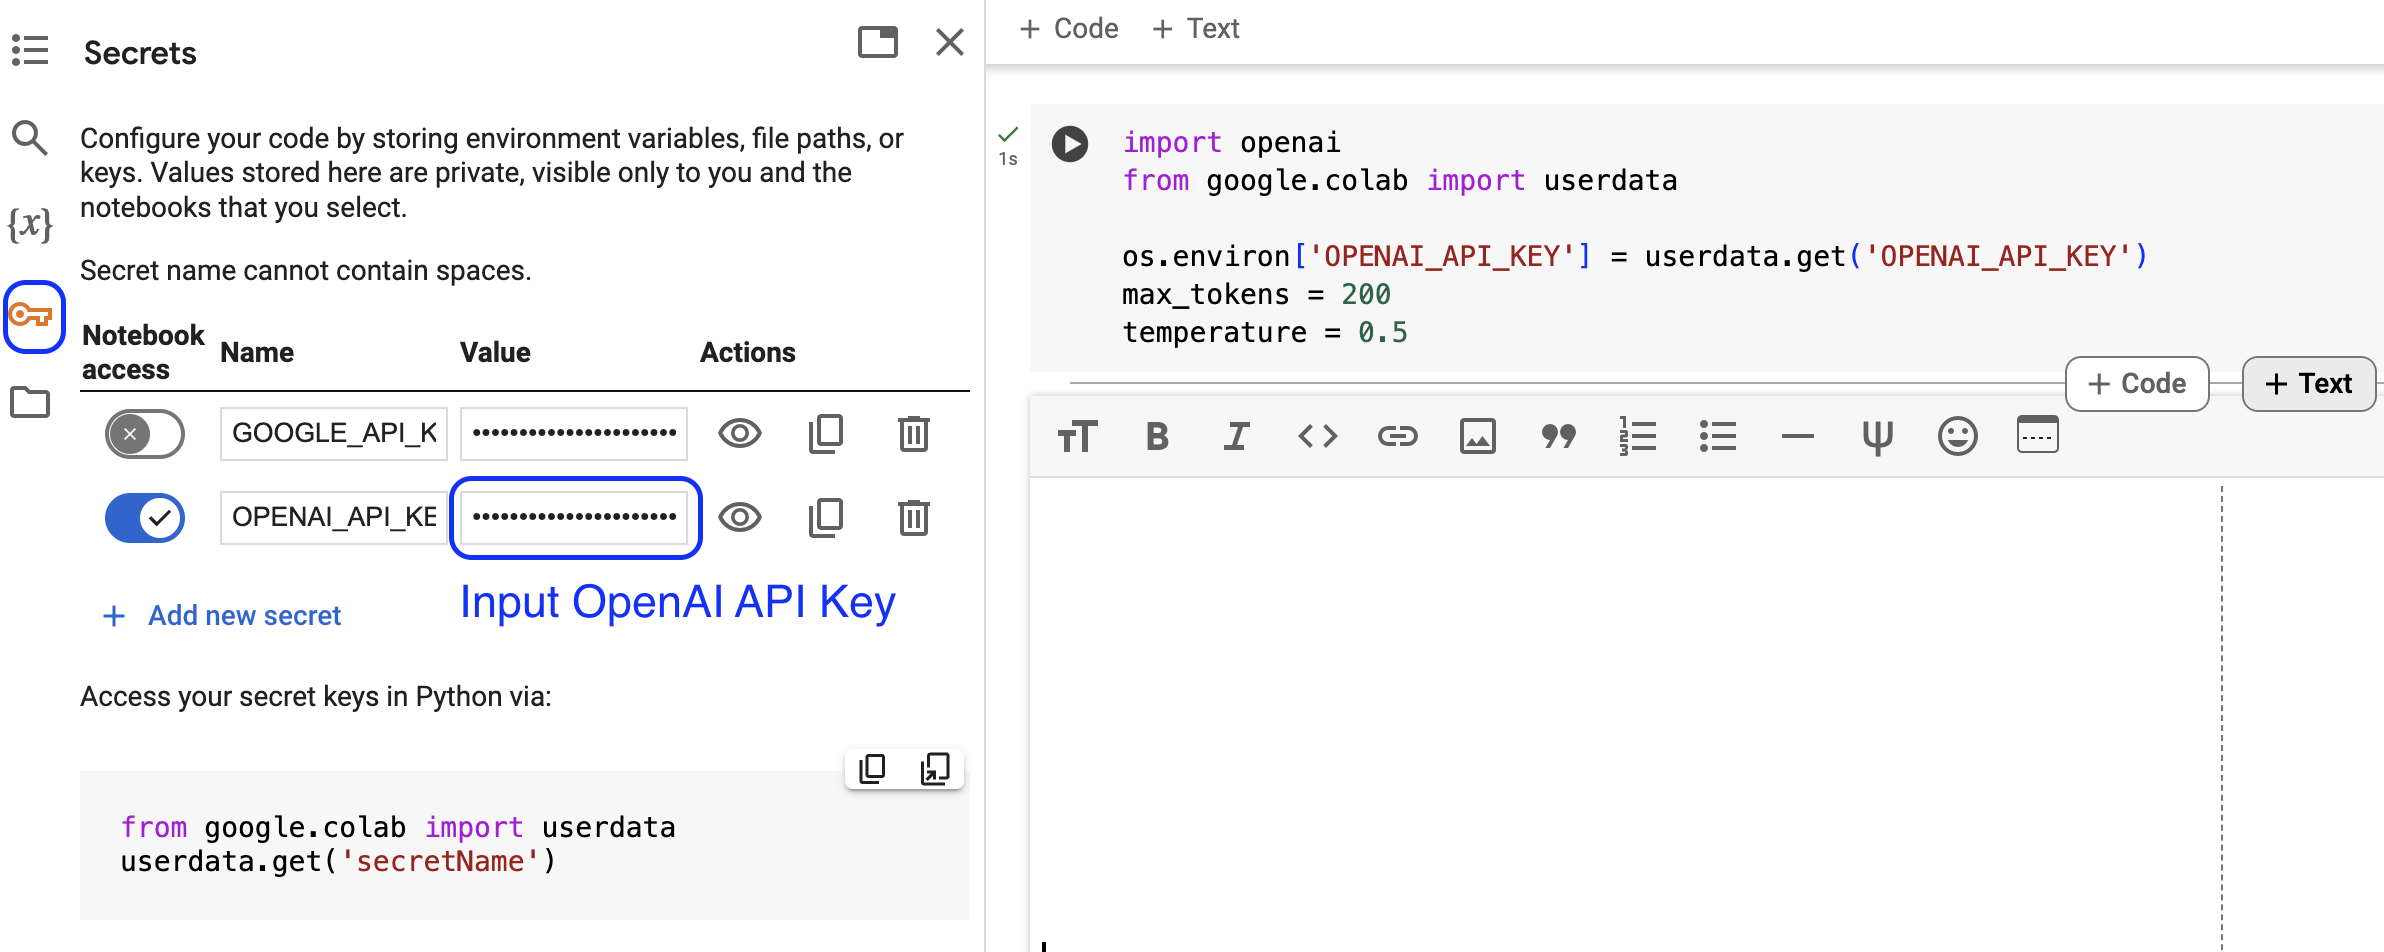

In [ ]:
import openai
from google.colab import userdata

os.environ['OPENAI_API_KEY'] = userdata.get('OPENAI_API_KEY')
max_tokens = 200
temperature = 0.5

## 2- Loading dataset

In [ ]:
# Loading data with FinanceDataReader
df_wti = fdr.DataReader('CL=F', '2024-02-01')
df_brt = fdr.DataReader('BZ=F', '2024-02-01')
print(df_wti.shape)
print(df_brt.shape)
print(type(df_wti))
print(type(df_brt))

display(df_wti.tail())
display(df_brt.tail())


(45, 6)
(45, 6)
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2024-04-01,83.139999,84.489998,82.599998,83.709999,83.709999,321059
2024-04-02,84.040001,85.500000,83.849998,85.150002,85.150002,344040
2024-04-03,85.459999,86.199997,84.849998,85.430000,85.430000,322549
2024-04-04,85.660004,87.220001,84.639999,86.589996,86.589996,359534
2024-04-05,86.860001,87.629997,86.320000,86.910004,86.910004,359534


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2024-04-01,86.930000,87.989998,86.400002,87.419998,87.419998,29598
2024-04-02,87.800003,89.279999,87.650002,88.919998,88.919998,40754
2024-04-03,89.209999,89.980003,88.680000,89.349998,89.349998,35138
2024-04-04,89.500000,91.300003,88.730003,90.650002,90.650002,38764
2024-04-05,91.010002,91.910004,90.570000,91.169998,91.169998,38764


In [ ]:
# Extracting the 'Close' column
wti = df_wti['Close']
brt = df_brt['Close']

print(type(wti))
print(type(brt))
display(wti.tail())
display(brt.tail())

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>


Date
2024-04-01    83.709999
2024-04-02    85.150002
2024-04-03    85.430000
2024-04-04    86.589996
2024-04-05    86.910004
Name: Close, dtype: float64

Date
2024-04-01    87.419998
2024-04-02    88.919998
2024-04-03    89.349998
2024-04-04    90.650002
2024-04-05    91.169998
Name: Close, dtype: float64

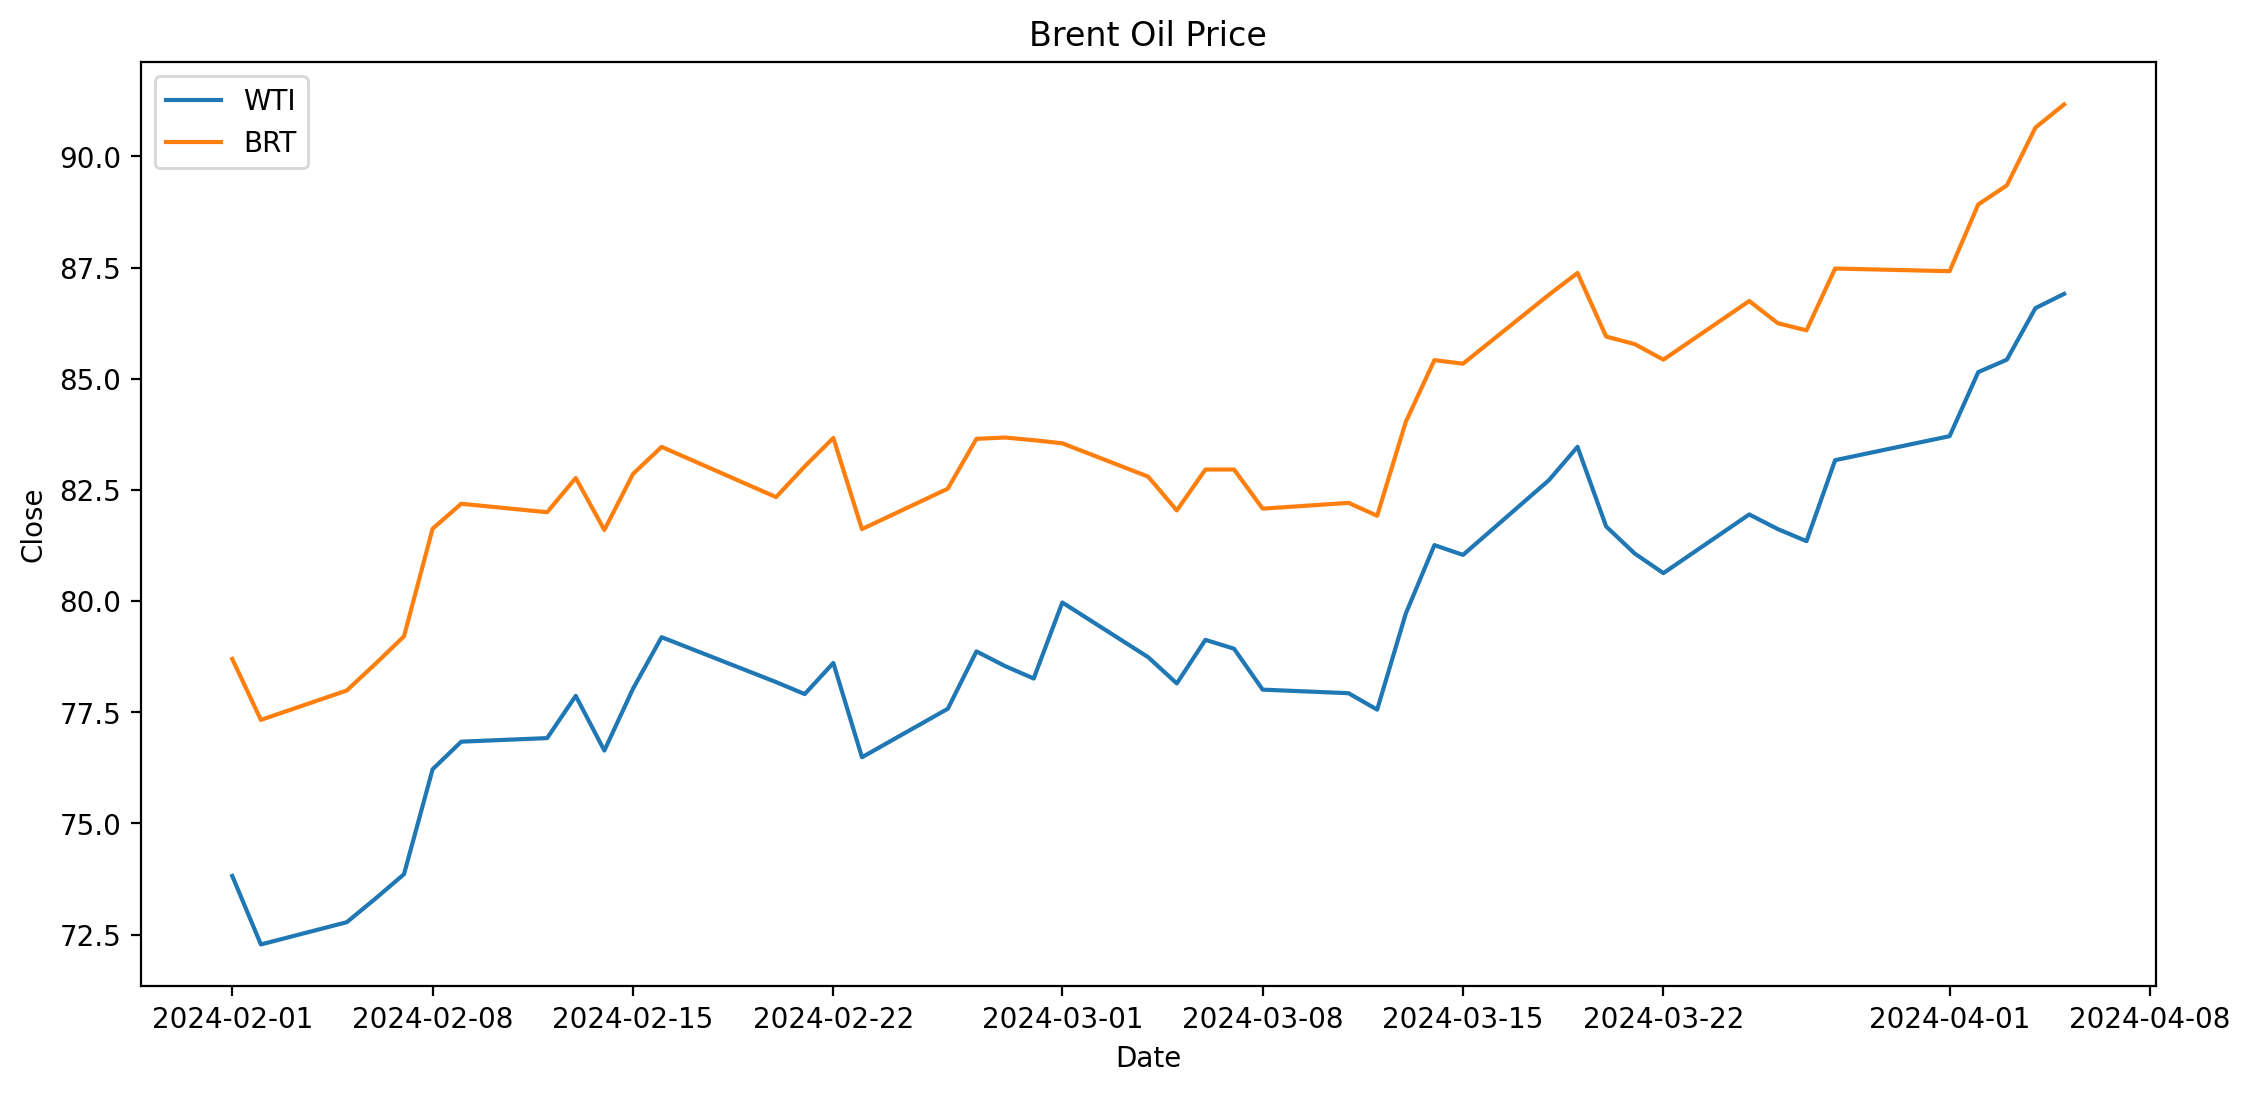

In [ ]:
sns.lineplot(data=wti, label='WTI')
plt.title('Crude Oil Price')
sns.lineplot(data=brt, label='BRT')
plt.title('Brent Oil Price')
plt.legend()
plt.show();

## 3- Handling missing value

In [ ]:
wti = wti.interpolate(method = 'time')
brt = brt.interpolate(method = 'time')
print(wti.isnull().sum())
print(brt.isnull().sum())

0
0


## 4- Log transformation

<Axes: xlabel='Date', ylabel='Close'>

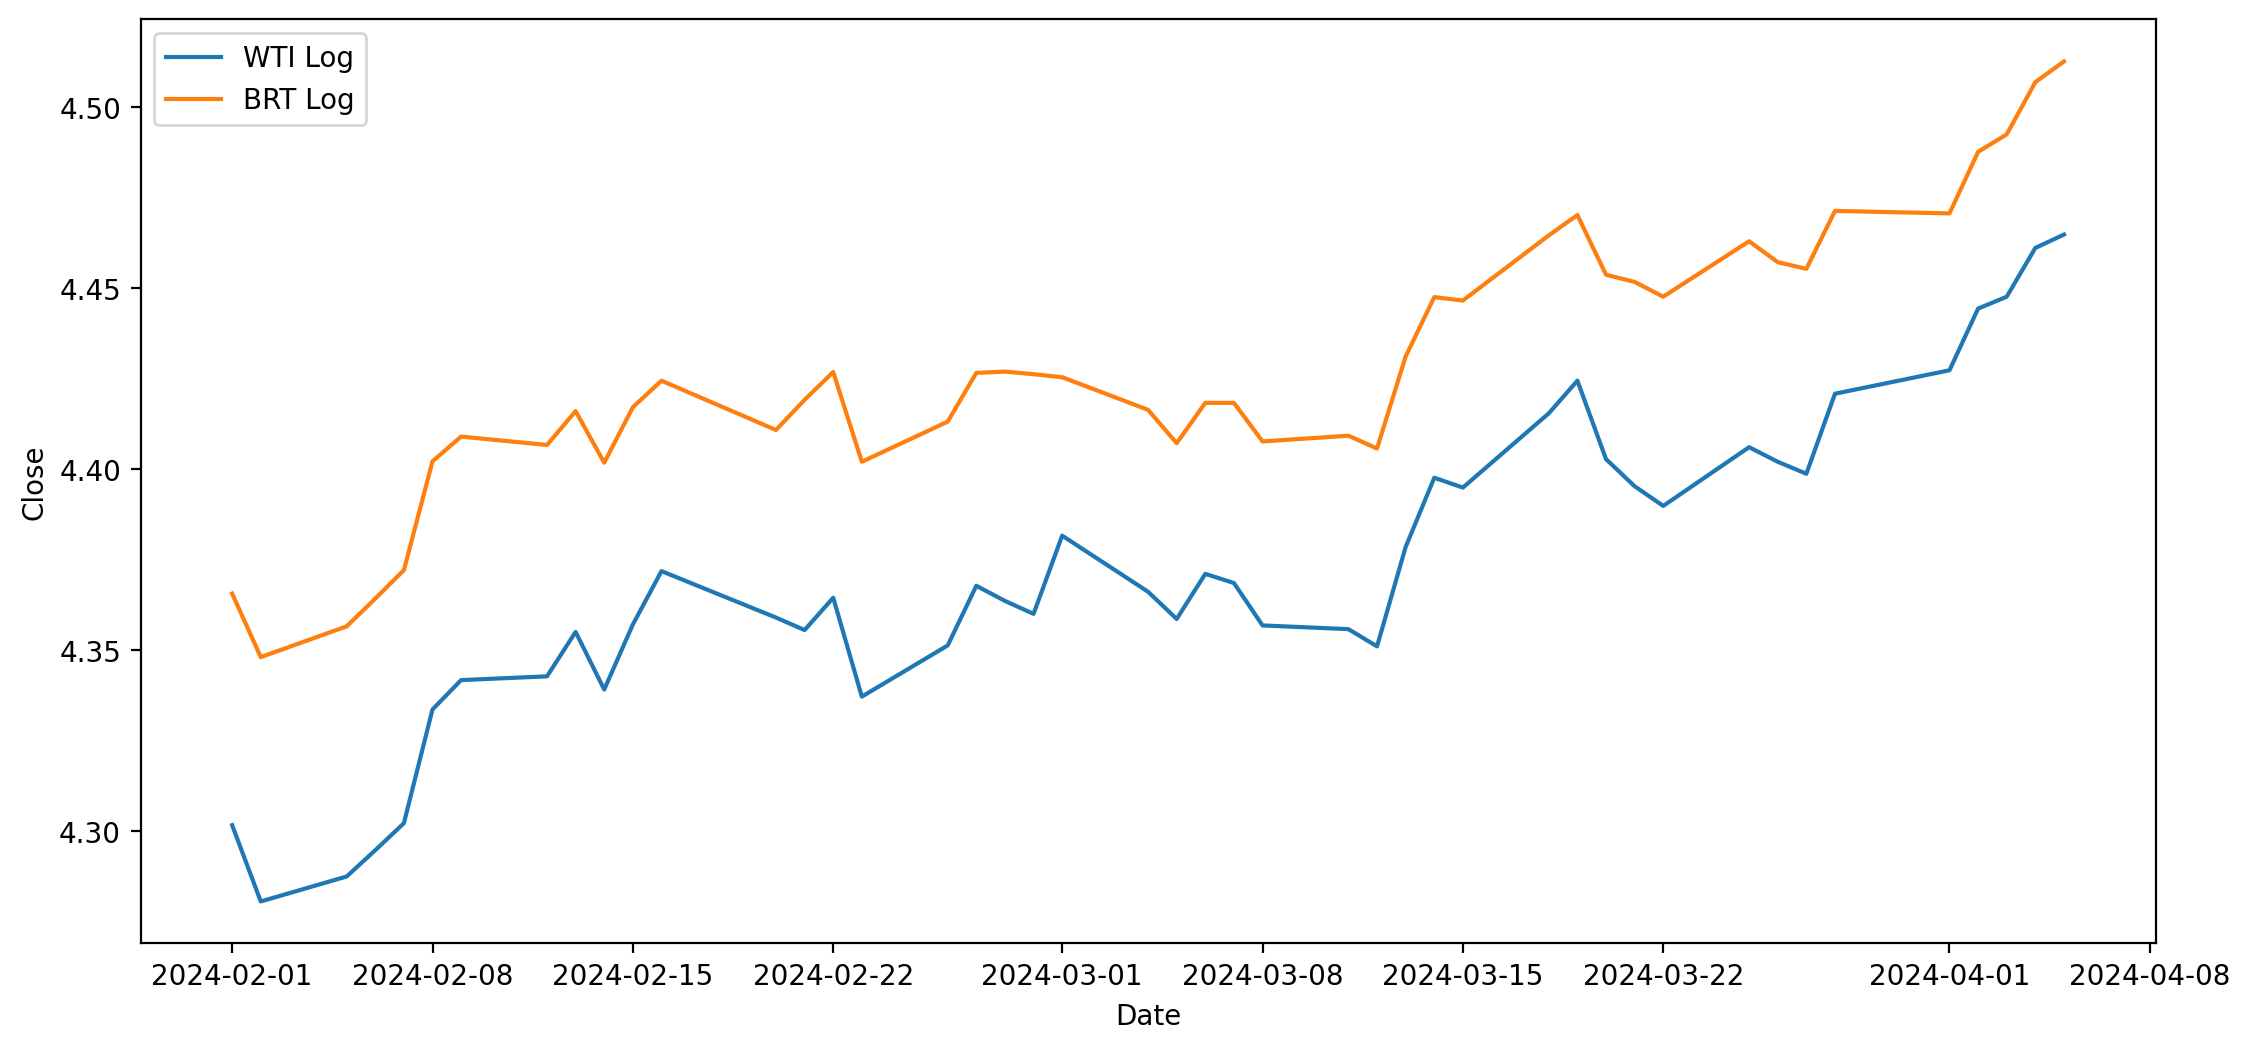

In [ ]:
# Log transformation
wti_log = np.log(wti)
brt_log = np.log(brt)
sns.lineplot(data=wti_log, label='WTI Log')
sns.lineplot(data=brt_log, label='BRT Log')

## 5- Moving average

In [ ]:
# Rolling mean and standard deviation
# https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.rolling.html
def rolling_ts(timeseries, window, name):

    rollmean = timeseries.rolling(window = window).mean()  # moving average time series
    rollstd = timeseries.rolling(window = window).std()  # moving standard deviation time series

    plt.plot(timeseries, color = 'blue', label = 'Original')
    plt.plot(rollmean, color = 'red', label = 'Rolling Mean')
    plt.plot(rollstd, color = 'black', label = 'Rolling Std')
    plt.title(f'Rolling Mean & Standard Deviation of Time Series: ({timeseries.name}) of ({name}) in windiow ({window}) Days')
    plt.ylabel('Price')
    plt.xlabel('Date')
    plt.legend(loc = 'best')
    plt.grid(True)

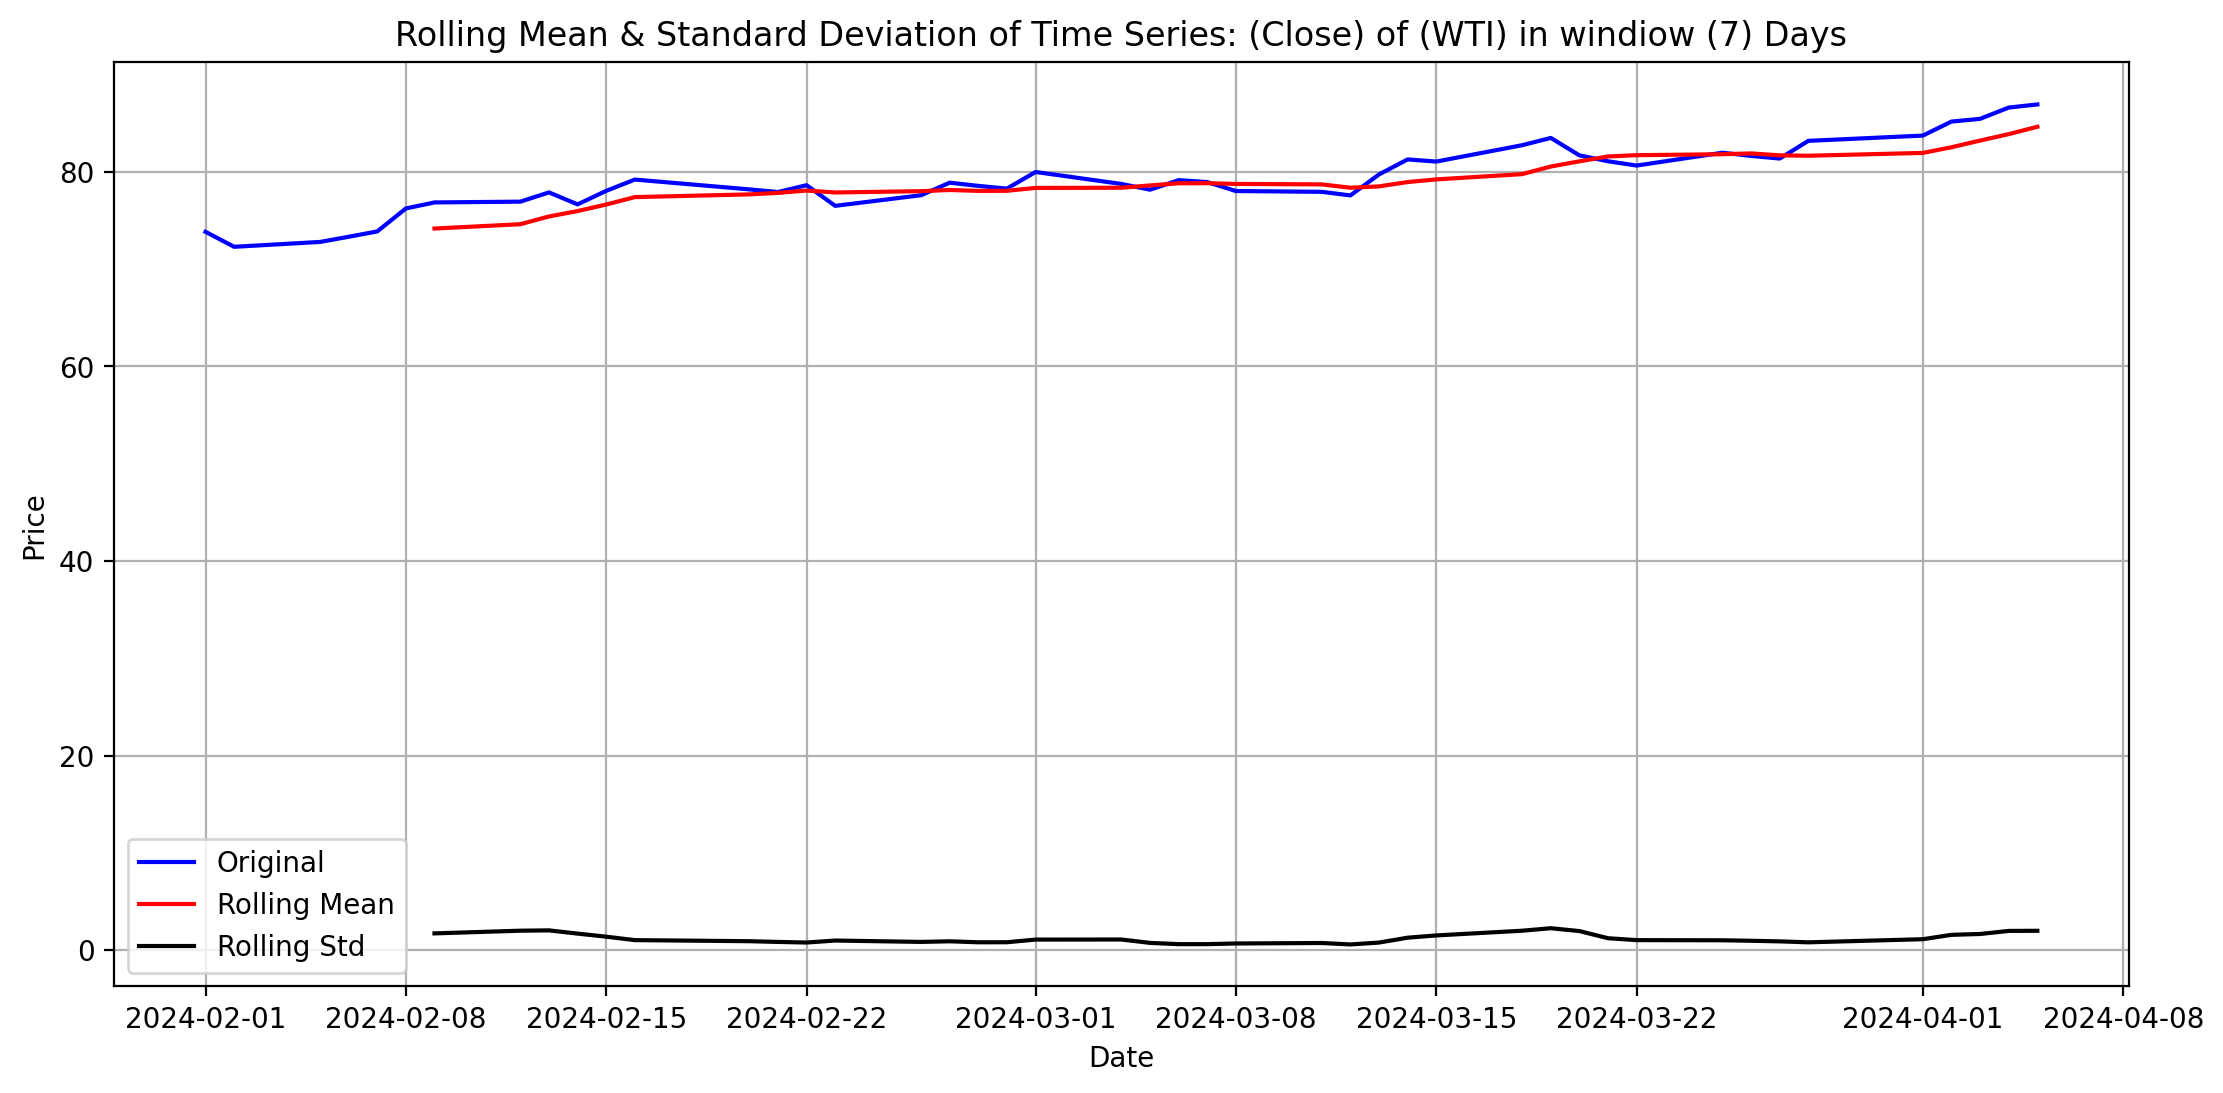

In [ ]:
rolling_ts(wti, 7, 'WTI')

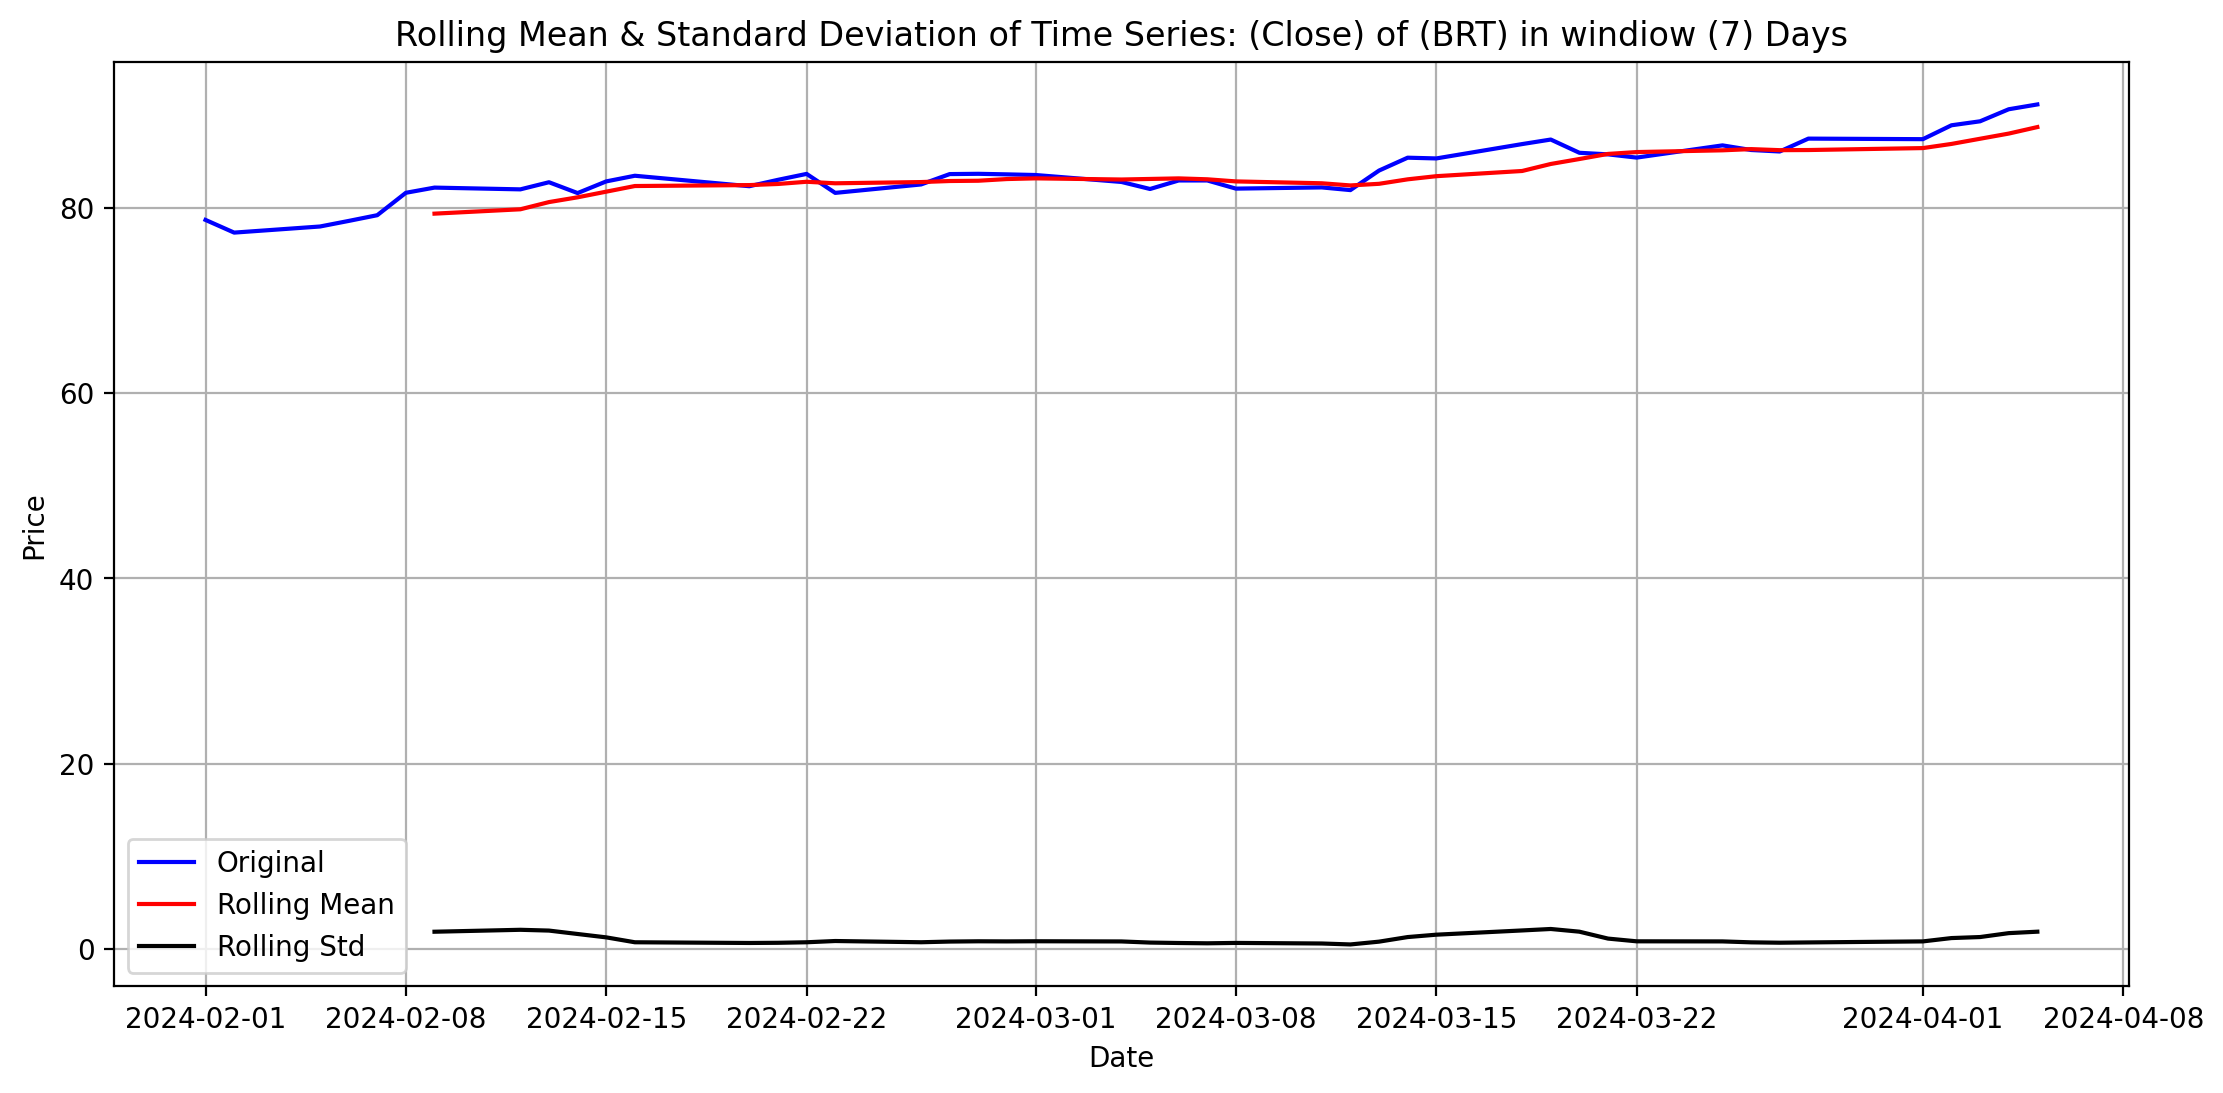

In [ ]:
rolling_ts(brt, 7, 'BRT')

## 6- Time series decomposition

In [ ]:
# Decomposition of time series
# https://www.statsmodels.org/dev/generated/statsmodels.tsa.seasonal.seasonal_decompose.html
def decomposition_ts(timeseries, period, name):

    from statsmodels.tsa.seasonal import seasonal_decompose
    decomposition = seasonal_decompose(timeseries, model = 'additive', period = period)
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid

    plt.subplot(411)
    plt.plot(timeseries, label = 'Origianl', color = 'purple')
    plt.legend(loc = 'best')
    plt.grid(True)
    plt.title(f'Decomposition of Time Series : ({timeseries.name}) of ({name}) in period ({period})')

    plt.subplot(412)
    plt.plot(trend, label = 'Trend', color = 'blue')
    plt.legend(loc = 'best')
    plt.grid(True)

    plt.subplot(413)
    plt.plot(seasonal, label = 'Seasonality', color = 'green')
    plt.legend(loc = 'best')
    plt.grid(True)

    plt.subplot(414)
    plt.plot(residual, label = 'Residuals', color = 'orange')
    plt.legend(loc = 'best')
    plt.grid(True)

    plt.tight_layout()

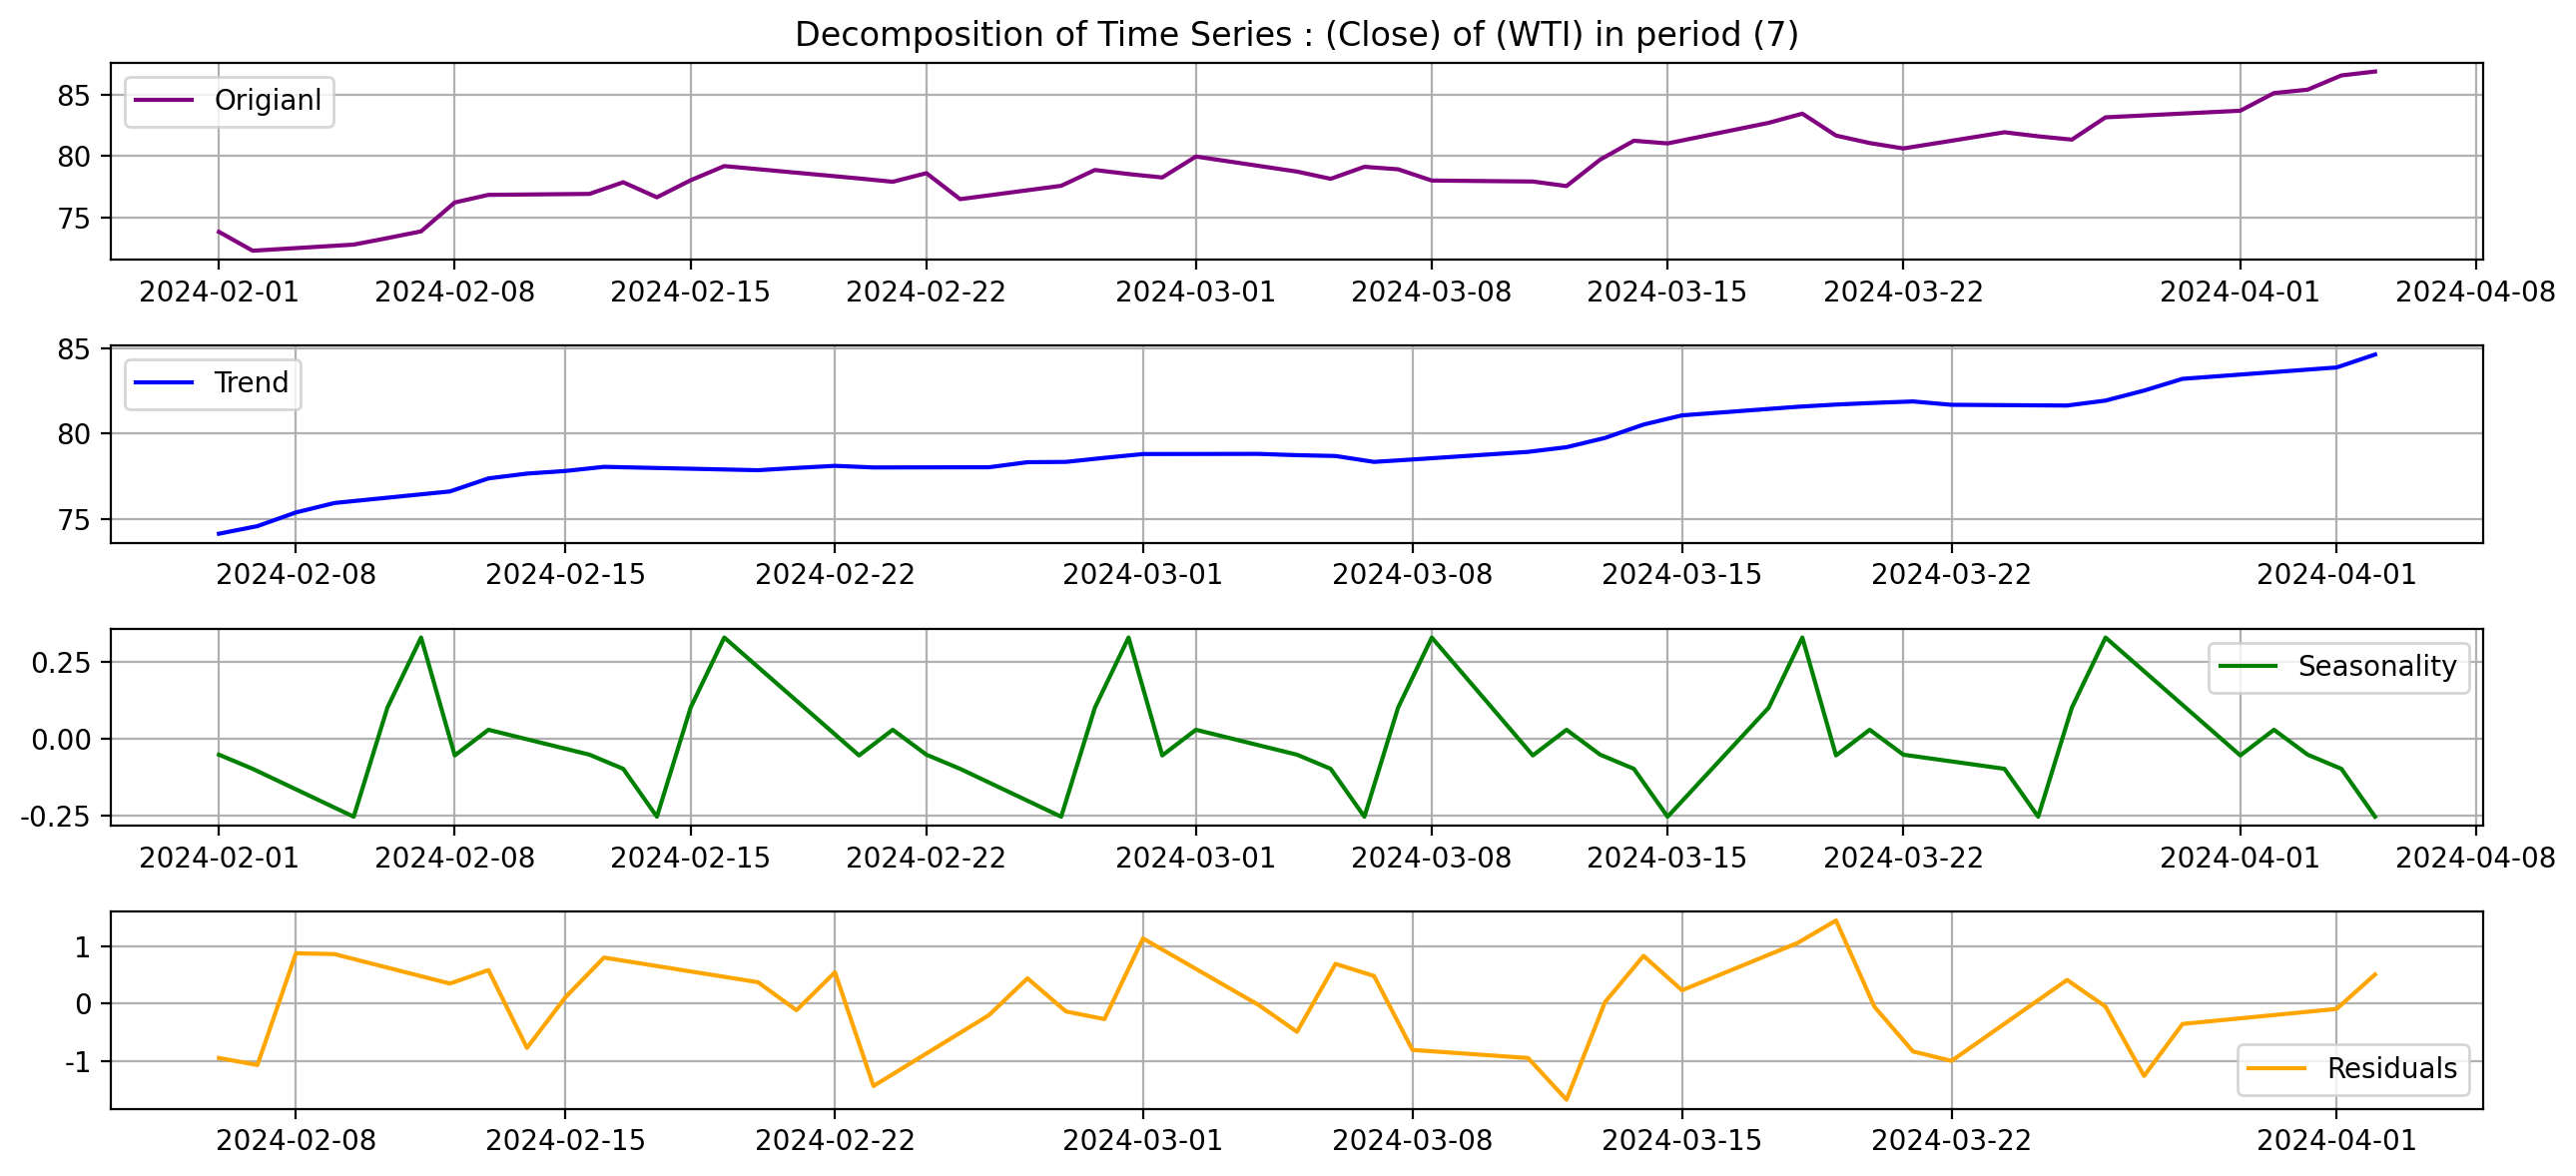

In [ ]:
decomposition_ts(wti, 7, 'WTI')

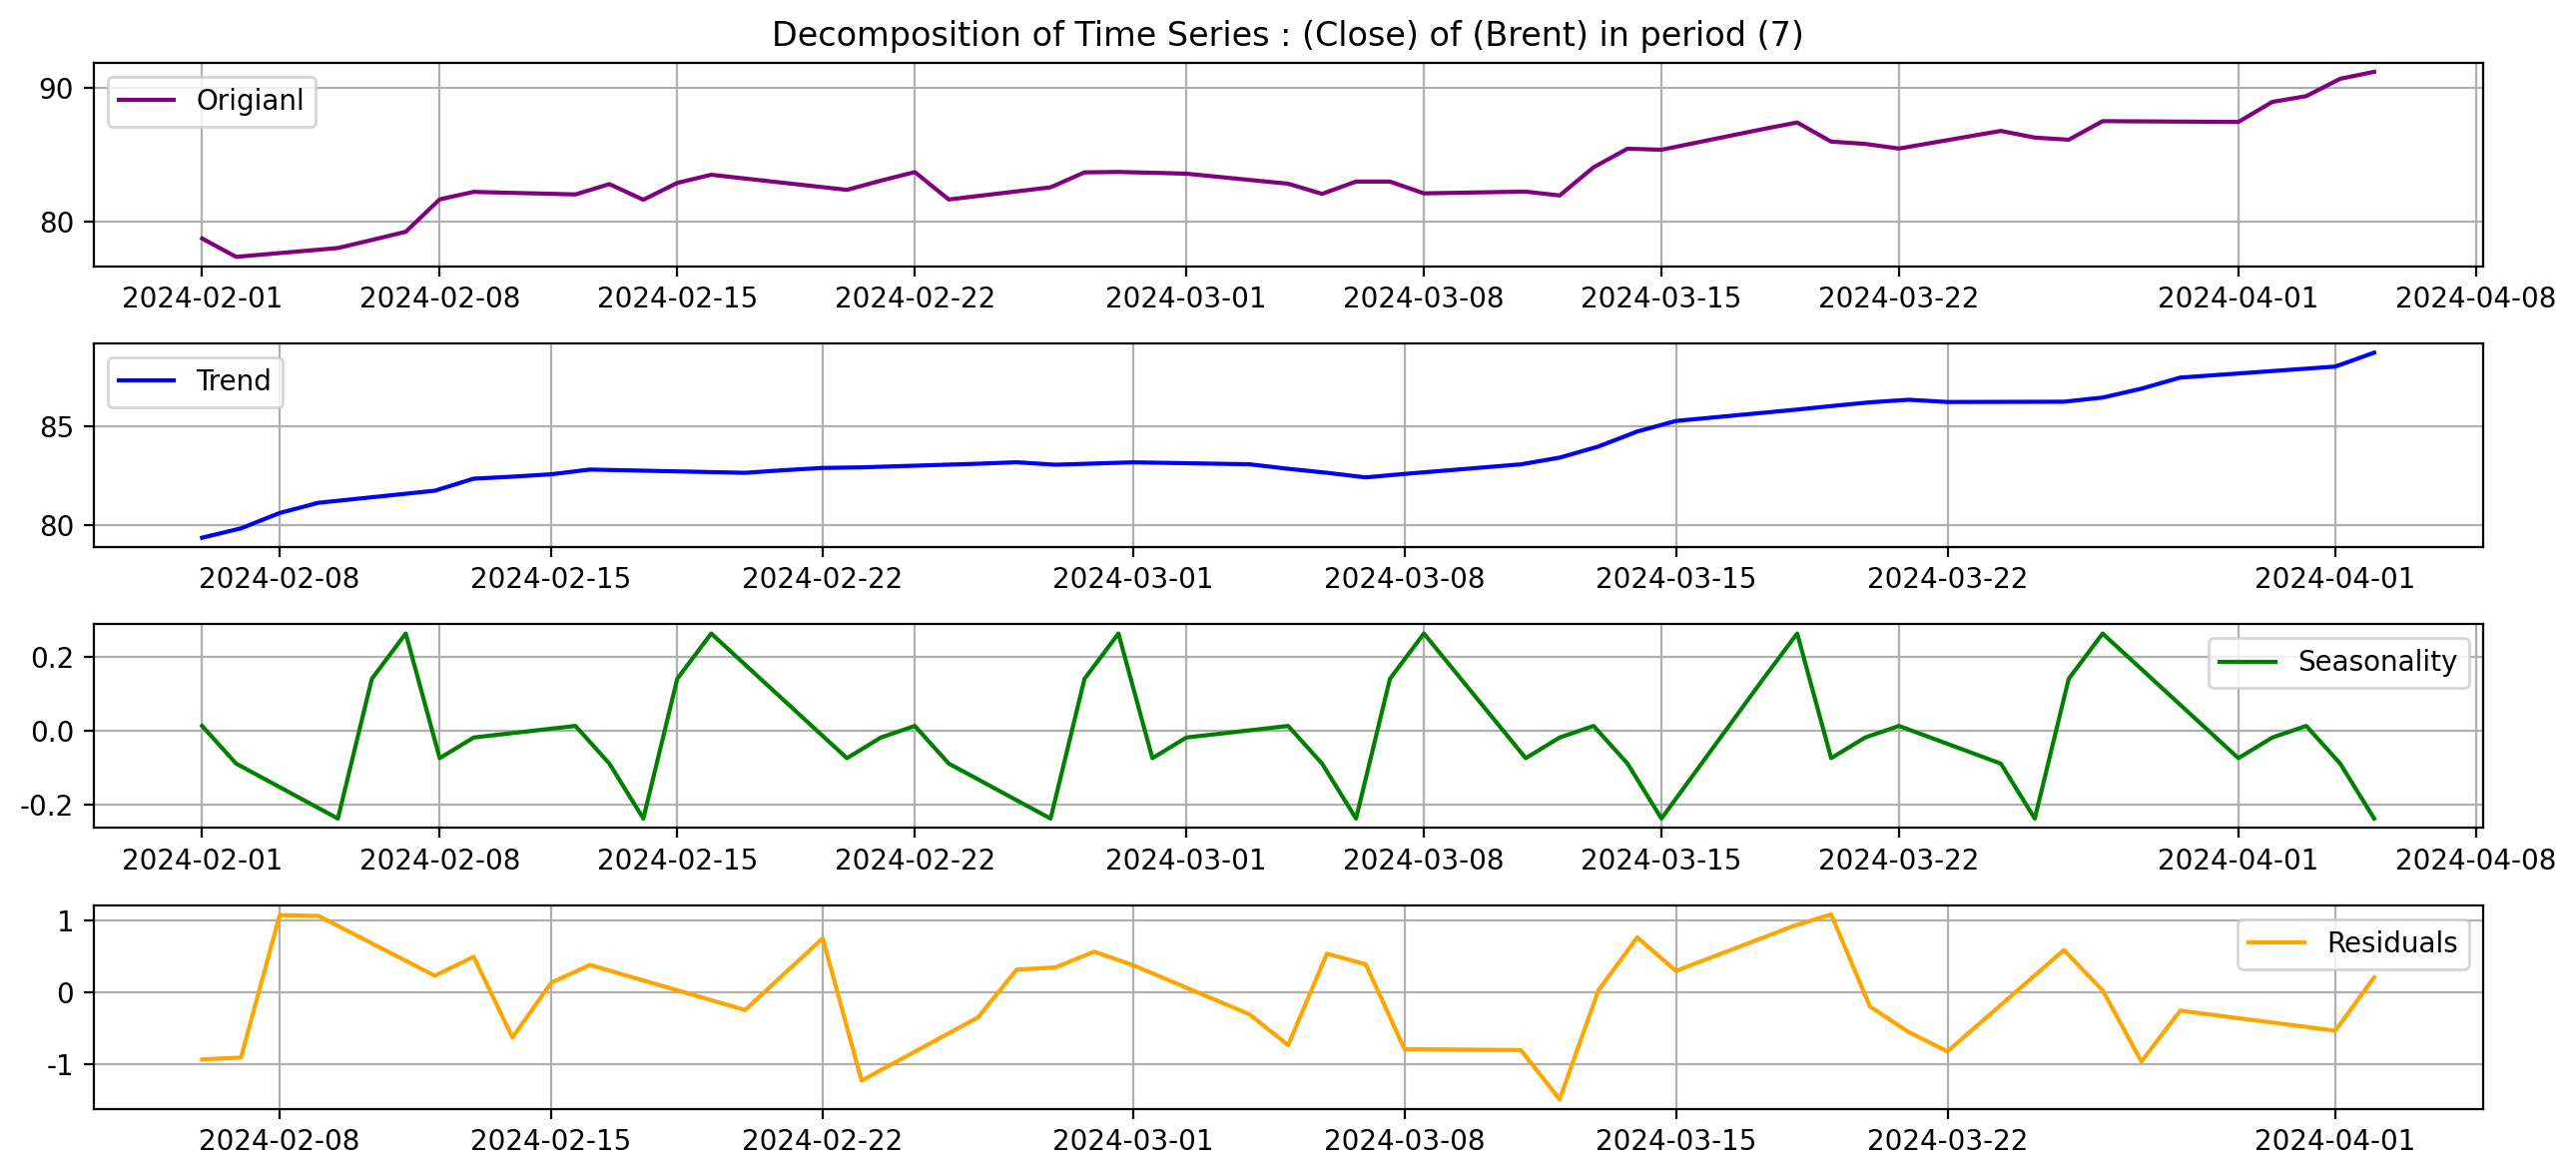

In [ ]:
decomposition_ts(brt, 7, 'Brent')

## 7- ADF test

In [ ]:
# Augmented Dickey-Fuller Test
# https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.adfuller.html

def adf_ts(timeseries):

    dftest = adfuller(timeseries, autolag='AIC')
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)


    # OpenAI API
    client = openai.OpenAI(
        api_key=os.environ['OPENAI_API_KEY'],
    )

    completion = openai.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=[
            {
                "role": "user",
                "content": str(dfoutput) +
                'Feedback with simply meaning and conclusion in itemized list with easy understandable sentences. Finally, mention if the dataset is stationary or not.',
            },
        ],
        max_tokens = max_tokens,
        temperature = temperature
    )
    print('===================================================================================')
    print('Summary of ADF Test')
    print(completion.choices[0].message.content)
    print('-----------------------------------------------------------------------------------')
    print(completion.usage)
    print('===================================================================================')

In [ ]:
adf_ts(wti)

Results of Dickey-Fuller Test:
Test Statistic                 -0.455959
p-value                         0.900328
#Lags Used                      0.000000
Number of Observations Used    44.000000
Critical Value (1%)            -3.588573
Critical Value (5%)            -2.929886
Critical Value (10%)           -2.603185
dtype: float64
Summary of ADF Test
- The test statistic is -0.455959, which is greater than the critical values at all significance levels (1%, 5%, and 10%).
- The p-value is 0.900328, which is higher than the typical significance levels of 0.01, 0.05, and 0.10.
- The number of lags used is 0, and the number of observations used is 44.
- Since the test statistic is greater than the critical values and the p-value is higher than the significance levels, we fail to reject the null hypothesis.
- Therefore, we can conclude that the dataset is non-stationary.

Overall, the dataset is non-stationary based on the ADF test results.
--------------------------------------------------

In [ ]:
wti_log = wti_log.replace([np.inf, -np.inf], np.nan).dropna()
adf_ts(wti_log)

Results of Dickey-Fuller Test:
Test Statistic                 -0.583640
p-value                         0.874636
#Lags Used                      0.000000
Number of Observations Used    44.000000
Critical Value (1%)            -3.588573
Critical Value (5%)            -2.929886
Critical Value (10%)           -2.603185
dtype: float64
Summary of ADF Test
- The test statistic is -0.583640, which is greater than the critical values at all significance levels.
- The p-value is 0.874636, which is greater than the significance level of 0.05.
- The number of lags used is 0, and the number of observations used is 44.

Based on the above results:
- We fail to reject the null hypothesis that the time series data is non-stationary.
- The dataset is not stationary.

In conclusion, the time series data is likely non-stationary as the test statistic is not significant and the p-value is greater than the significance level.
--------------------------------------------------------------------------------

## 8- ACF/PACF plot

ACF values:
[ 1.          0.86466724  0.71832757  0.60257656  0.46471313  0.3687933
  0.32160009  0.29530436  0.27990974  0.26182921  0.24141823  0.24148179
  0.23267383  0.14936947  0.07642238  0.03394838 -0.04530854 -0.07520871
 -0.0500468  -0.04769151 -0.04122688]

PACF values:
[ 1.          0.88431877 -0.13891865  0.05304743 -0.22173881  0.14920845
  0.10241368  0.10342416 -0.00210585 -0.0443764   0.00725814  0.1704208
 -0.02295132 -0.49394495  0.00888374  0.14651573 -0.22720532  0.23600713
  0.14862263 -0.32389645  0.05951353]


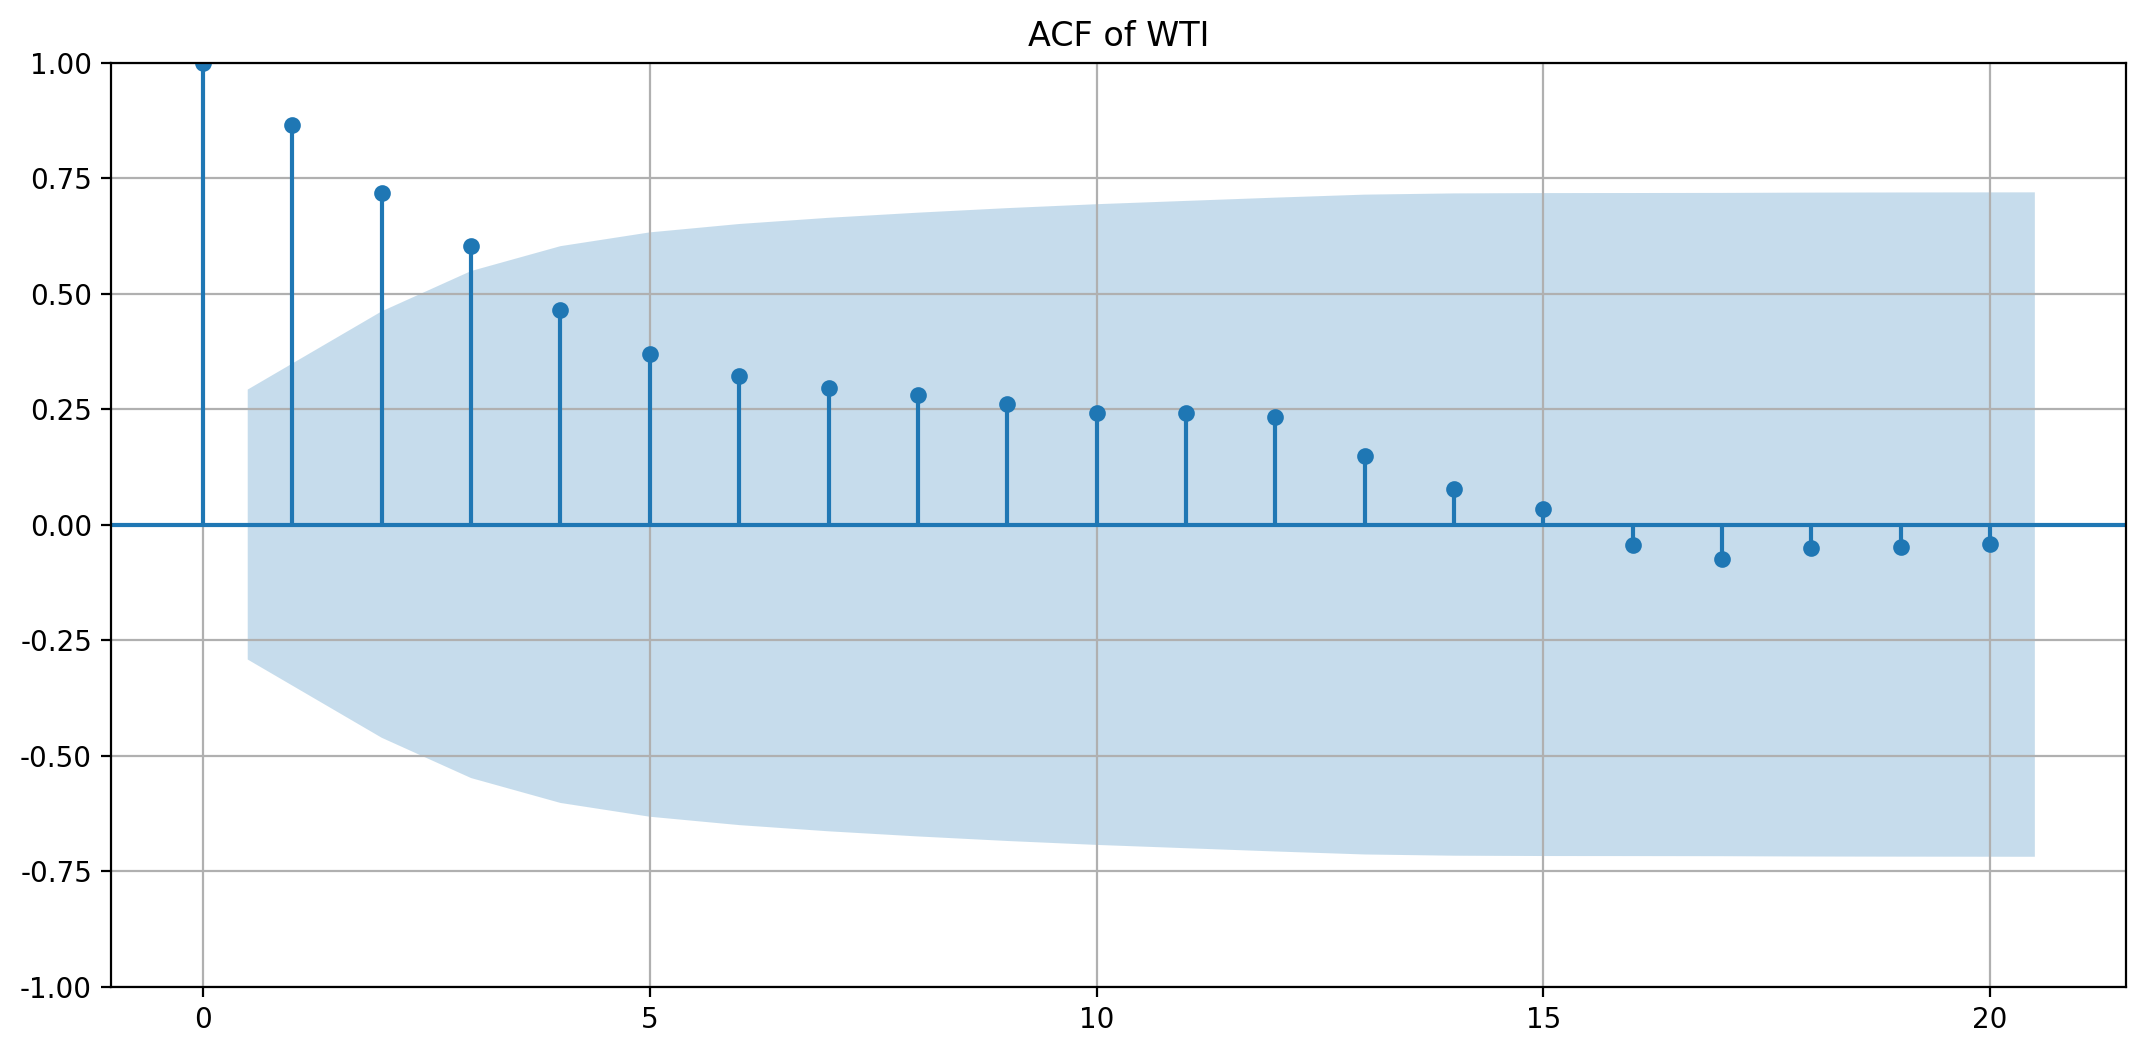

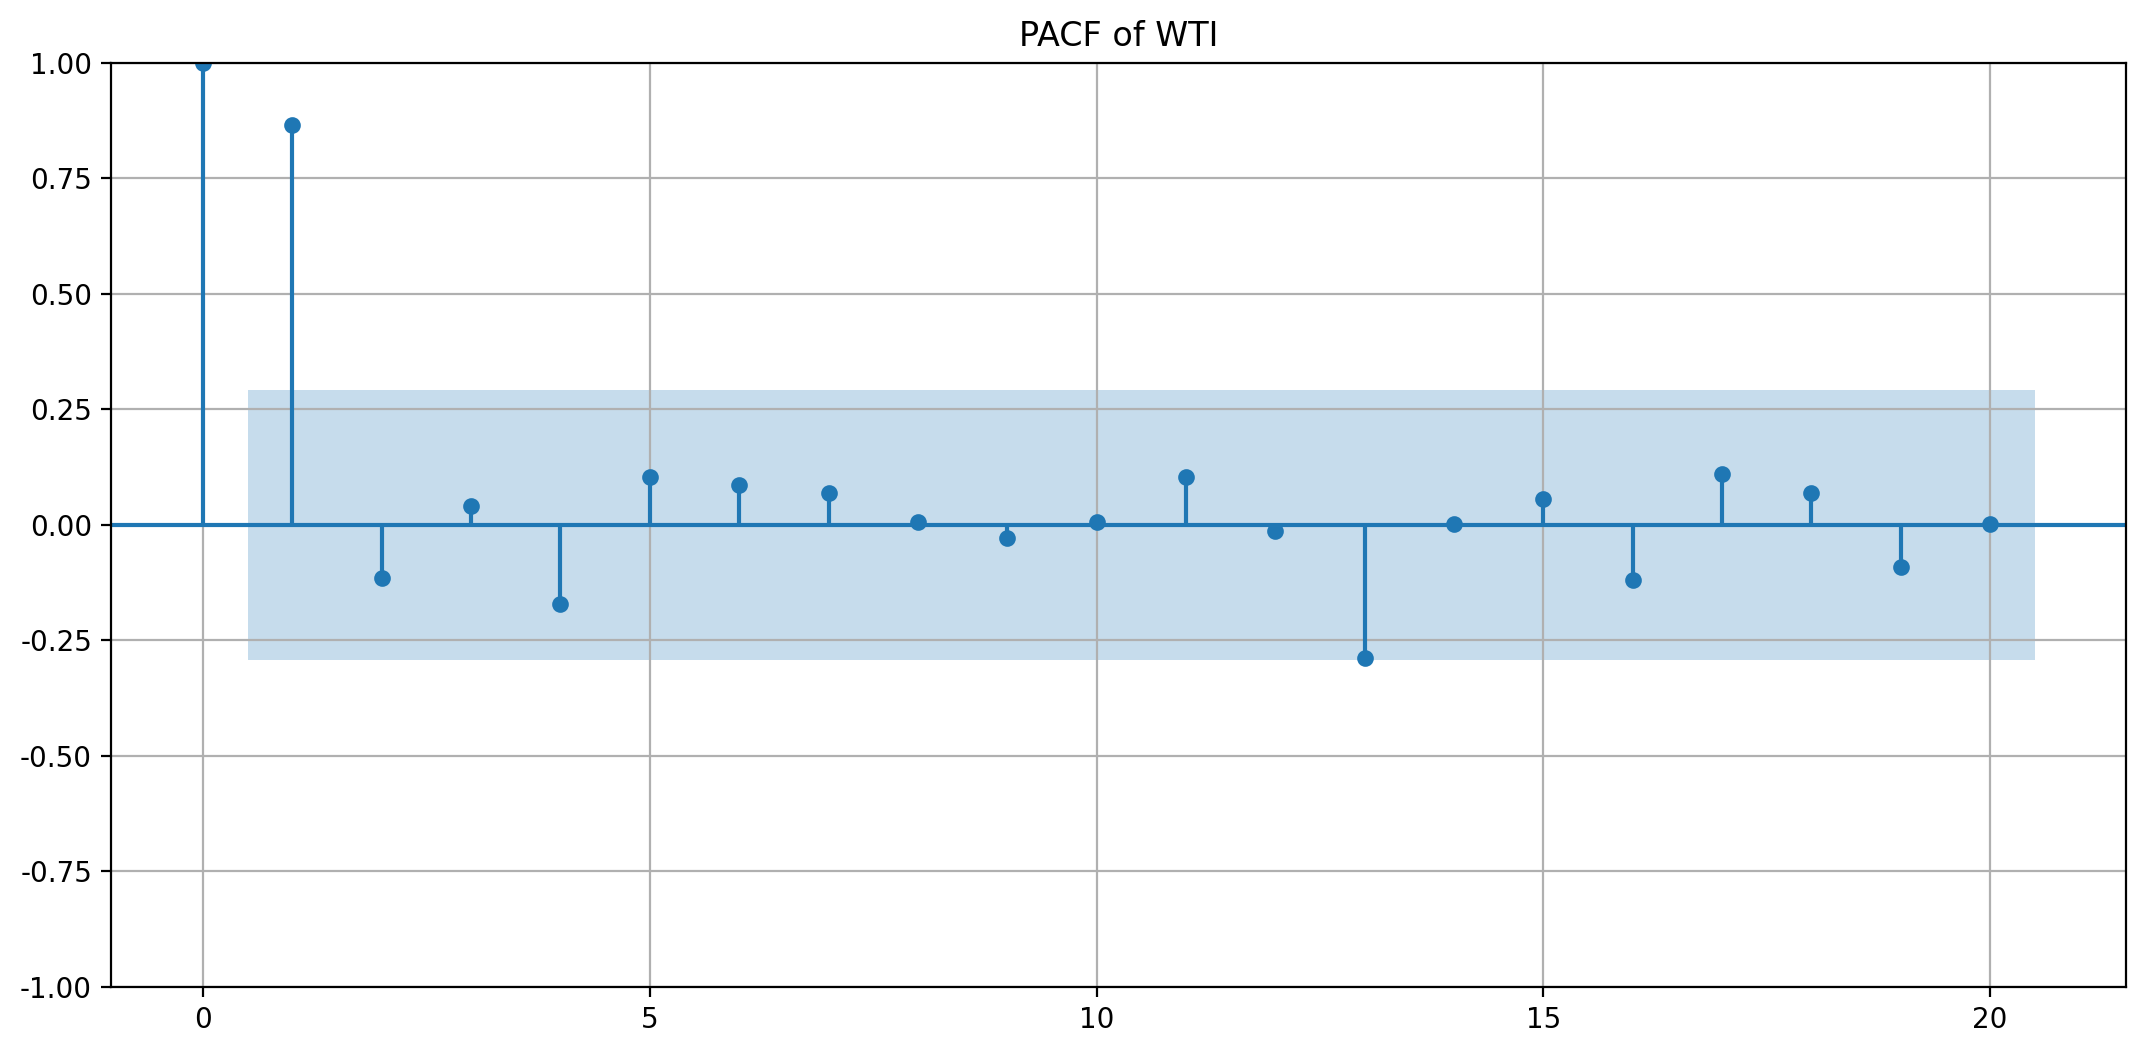

Summary of ACF/PACF
- ACF (Auto-correlation Function) shows a gradual decrease in values as the lag increases, indicating a decreasing relationship between the observations at different time lags.
- PACF (Partial Auto-correlation Function) shows a mix of positive and negative values, suggesting a more complex relationship between the observations at different time lags.
- The ACF values indicate a weak positive correlation between the observations at different time lags, while the PACF values show a mix of positive and negative correlations.
- Overall, the ACF and PACF results suggest a moderate level of correlation between the observations at different time lags, with some complex relationships present.
-----------------------------------------------------------------------------------
CompletionUsage(completion_tokens=130, prompt_tokens=315, total_tokens=445)


In [ ]:
lags = 20
timeseries = wti

# Calculate ACF and PACF
acf_values = acf(timeseries, nlags = lags)
pacf_values = pacf(timeseries, nlags = lags)

# Print ACF values
print("ACF values:")
print(acf_values)

# Print PACF values
print("\nPACF values:")
print(pacf_values)

# Plot ACF and PACF
plot_acf(timeseries, lags = lags, alpha = 0.05)
plt.title('ACF of WTI')
plt.grid(True)
plot_pacf(timeseries, lags = lags)
plt.title('PACF of WTI')
plt.grid(True)
plt.show()


# OpenAI
client = openai.OpenAI(
api_key=os.environ['OPENAI_API_KEY'],
)

completion = openai.chat.completions.create(
    model="gpt-3.5-turbo",
    messages=[
        {
            "role": "user",
            "content": str(acf_values) + str(pacf_values) +
            'This is ACF and PACF calculation result. Feedback with simply meaning and conclusion in itemized list with easy understandable sentences.',
        },
    ],
    max_tokens = max_tokens,
    temperature = temperature
)
print('===================================================================================')
print('Summary of ACF/PACF')
print(completion.choices[0].message.content)
print('-----------------------------------------------------------------------------------')
print(completion.usage)
print('===================================================================================')


ACF values:
[ 1.          0.86623907  0.71966094  0.60306229  0.46414716  0.36760938
  0.32166385  0.29330537  0.27698     0.25852143  0.23633147  0.23654556
  0.22888534  0.14837644  0.07796387  0.03628616 -0.04283029 -0.07230322
 -0.0471131  -0.0454427  -0.03902468]

PACF values:
[ 1.          0.88592632 -0.14749796  0.05310395 -0.22775447  0.15790409
  0.10961819  0.08361862  0.00454109 -0.05401168  0.01125024  0.17904179
 -0.02525212 -0.49066301  0.01455524  0.14836987 -0.23243769  0.25511835
  0.13472423 -0.33501953  0.0719315 ]


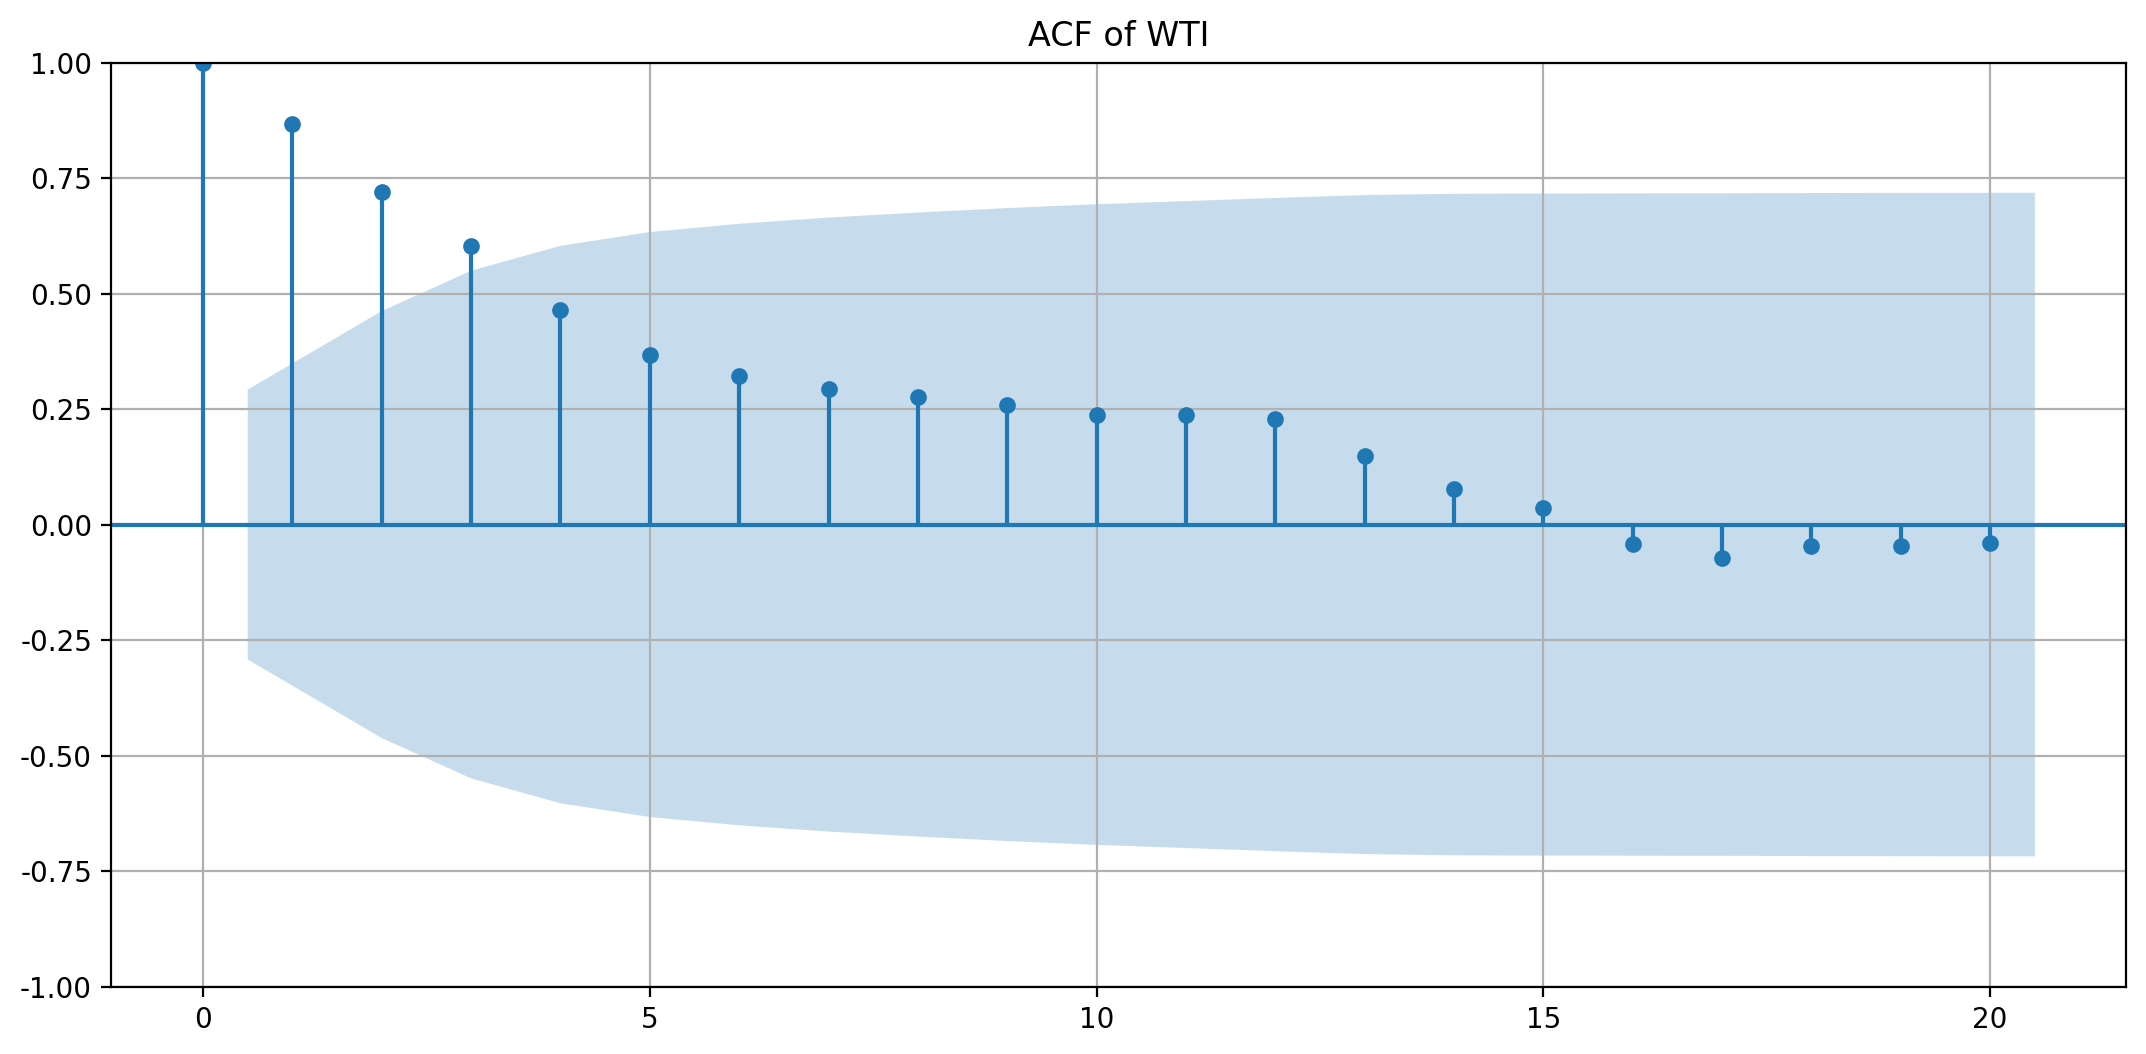

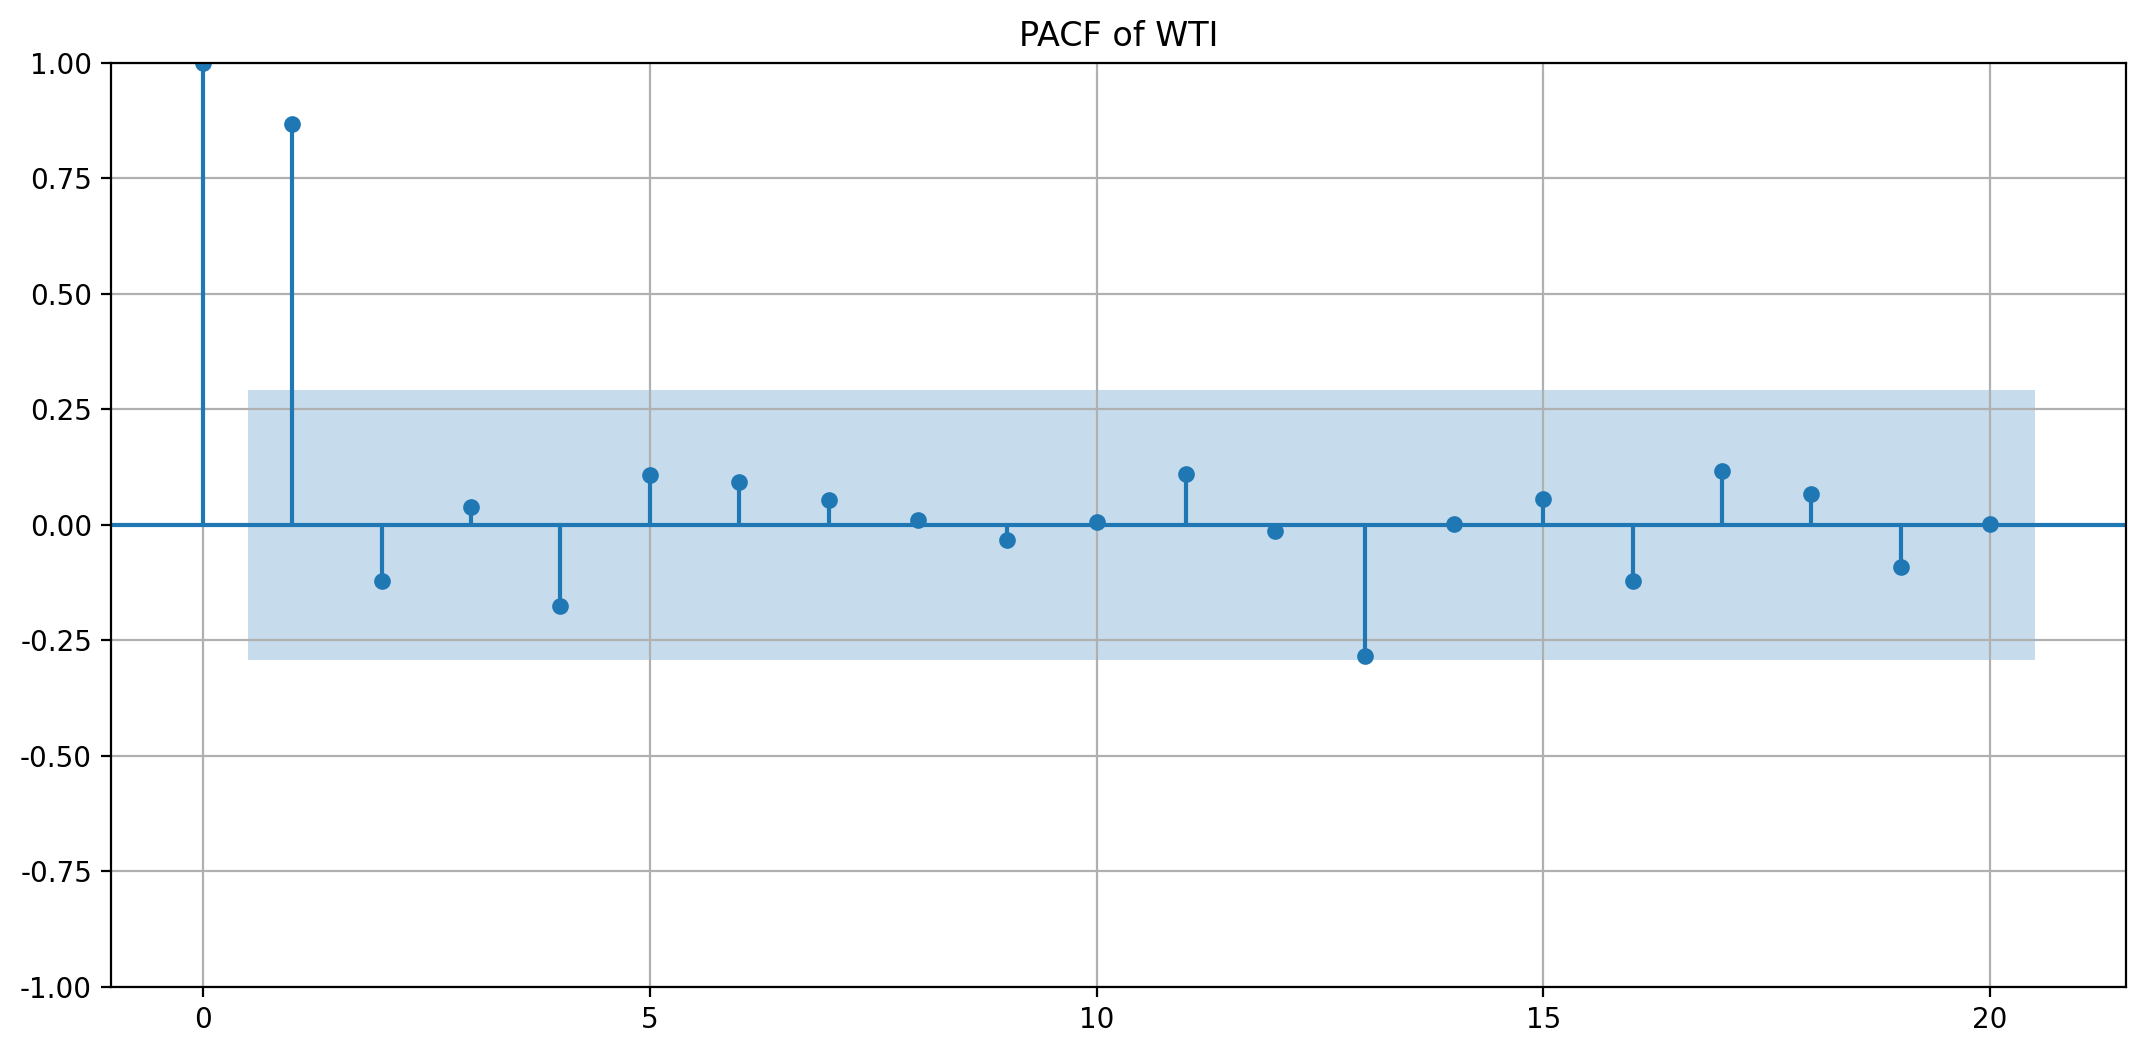

Summary of ACF/PACF
- The first set of values represents the Autocorrelation Function (ACF) values, which show the correlation between a time series and its lagged values.
- The second set of values represents the Partial Autocorrelation Function (PACF) values, which show the correlation between a time series and its lagged values after removing the effects of intervening values.

Meaning:
1. ACF values gradually decrease as the lag increases, indicating a decreasing correlation between the time series and its past values.
2. PACF values show a mix of positive and negative correlations, with some values being significant and others not.

Conclusion:
- The ACF and PACF values suggest that there is some correlation between the time series and its past values, but the strength of this correlation decreases as the lag increases. Further analysis is needed to determine the significance of the correlations and their impact on the time series.
-------------------------------------------------

In [ ]:
lags = 20
timeseries = wti_log

# Calculate ACF and PACF
acf_values = acf(timeseries, nlags = lags)
pacf_values = pacf(timeseries, nlags = lags)

# Print ACF values
print("ACF values:")
print(acf_values)

# Print PACF values
print("\nPACF values:")
print(pacf_values)

# Plot ACF and PACF
plot_acf(timeseries, lags = lags, alpha = 0.05)
plt.title('ACF of WTI')
plt.grid(True)
plot_pacf(timeseries, lags = lags)
plt.title('PACF of WTI')
plt.grid(True)
plt.show()


# OpenAI
client = openai.OpenAI(
api_key=os.environ['OPENAI_API_KEY'],
)

completion = openai.chat.completions.create(
    model="gpt-3.5-turbo",
    messages=[
        {
            "role": "user",
            "content": str(acf_values) + str(pacf_values) +
            'This is ACF and PACF calculation result. Feedback with simply meaning and conclusion in itemized list with easy understandable sentences.',
        },
    ],
    max_tokens = max_tokens,
    temperature = temperature
)
print('===================================================================================')
print('Summary of ACF/PACF')
print(completion.choices[0].message.content)
print('-----------------------------------------------------------------------------------')
print(completion.usage)
print('===================================================================================')

## 9- Differencing

Results of Dickey-Fuller Test:
Test Statistic                 -3.457887
p-value                         0.009137
#Lags Used                      6.000000
Number of Observations Used    37.000000
Critical Value (1%)            -3.620918
Critical Value (5%)            -2.943539
Critical Value (10%)           -2.610400
dtype: float64
Summary of ADF Test
- The test statistic is -3.457887, which is lower than the critical values at 1%, 5%, and 10% significance levels.
- The p-value is 0.009137, which is less than the significance level of 0.05.
- The number of lags used is 6, and the number of observations used is 37.

Conclusion:
- The null hypothesis that the data is non-stationary is rejected.
- The dataset is stationary.

Overall, based on the test results, we can conclude that the dataset is stationary.
-----------------------------------------------------------------------------------
CompletionUsage(completion_tokens=117, prompt_tokens=115, total_tokens=232)


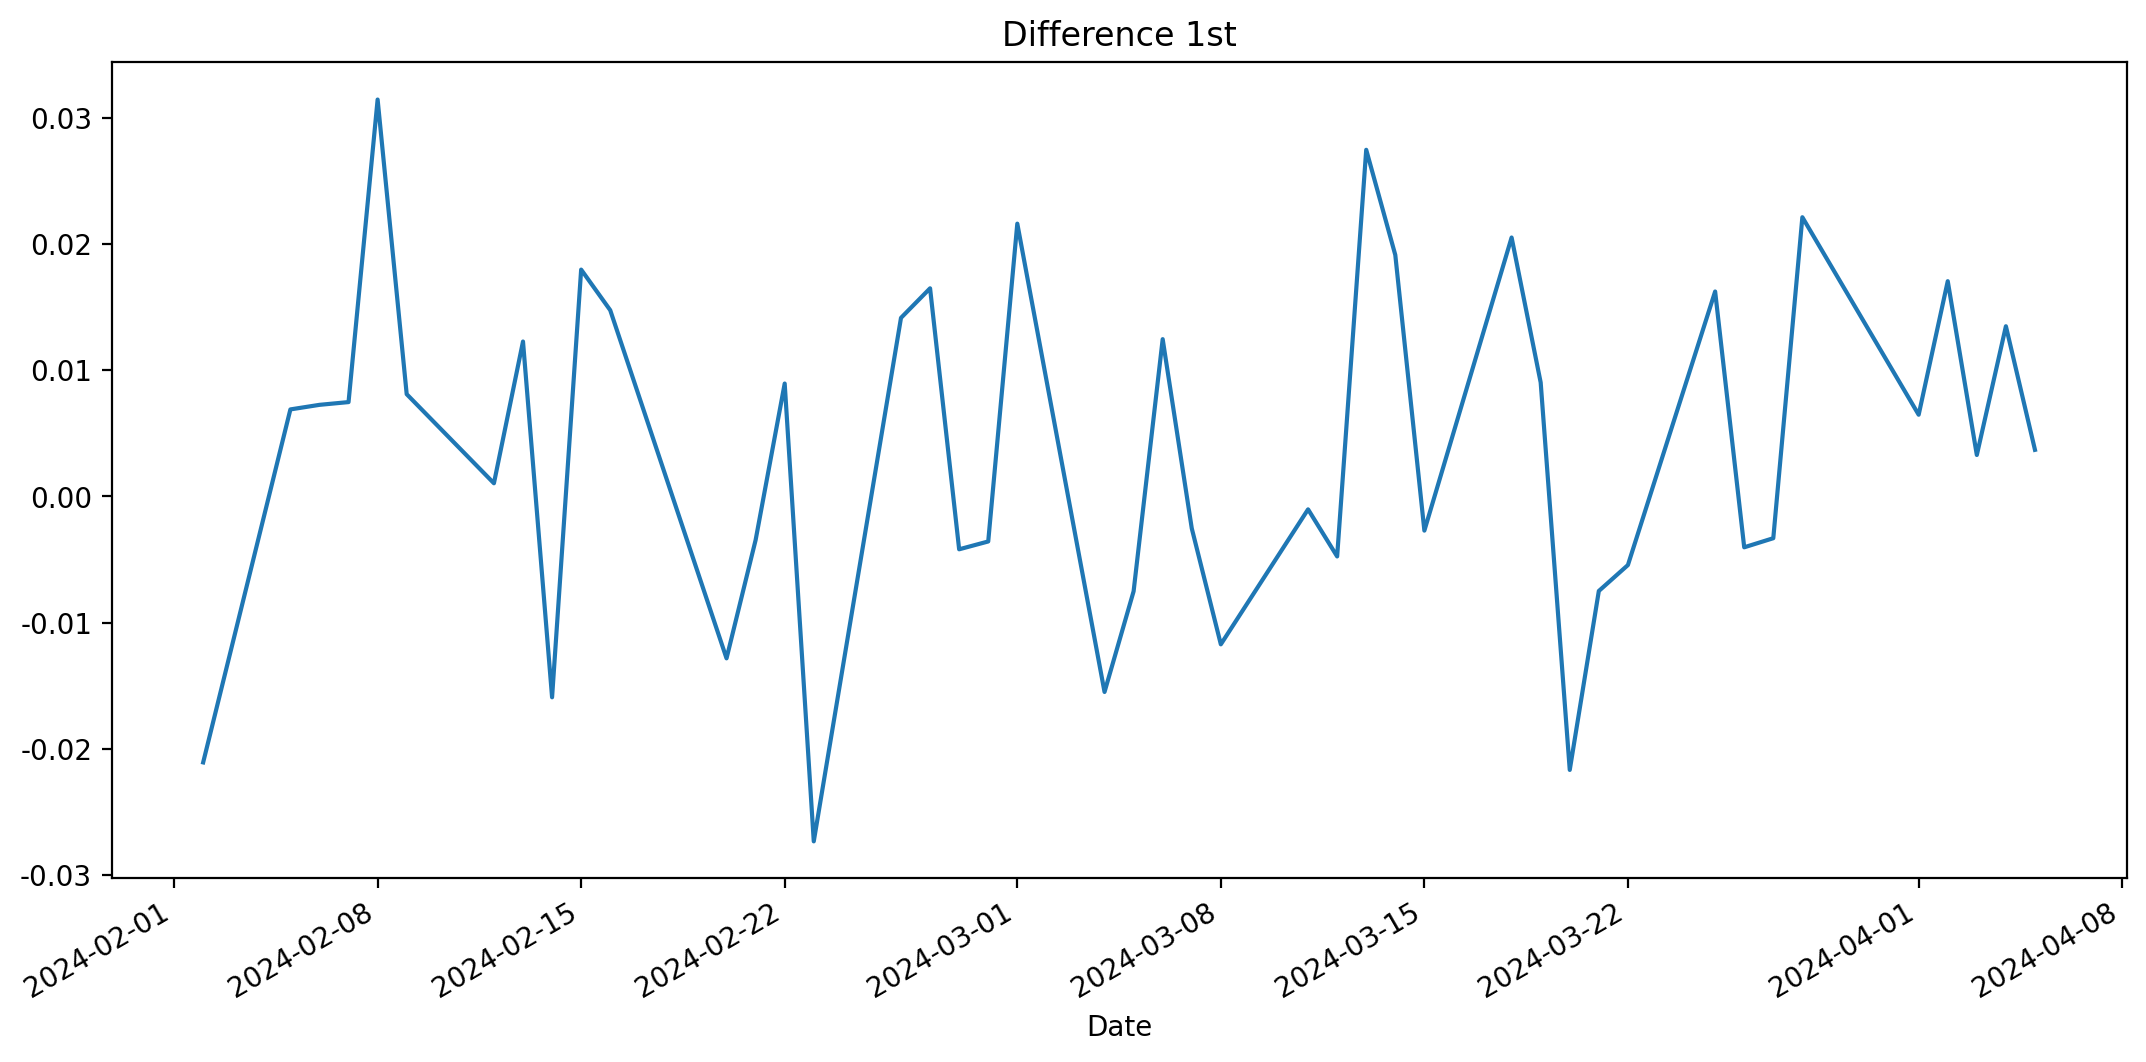

In [ ]:
wti_log_diff_1 = wti_log.diff(periods=1).iloc[1:]
wti_log_diff_1.plot(title='Difference 1st')

adf_ts(wti_log_diff_1)

## 10- Split dataset train & test

In [ ]:
print(type(wti_log_diff_1))
wti_log_diff_1.head()

<class 'pandas.core.series.Series'>


Date
2024-02-02   -0.021082
2024-02-05    0.006894
2024-02-06    0.007256
2024-02-07    0.007474
2024-02-08    0.031452
Name: Close, dtype: float64

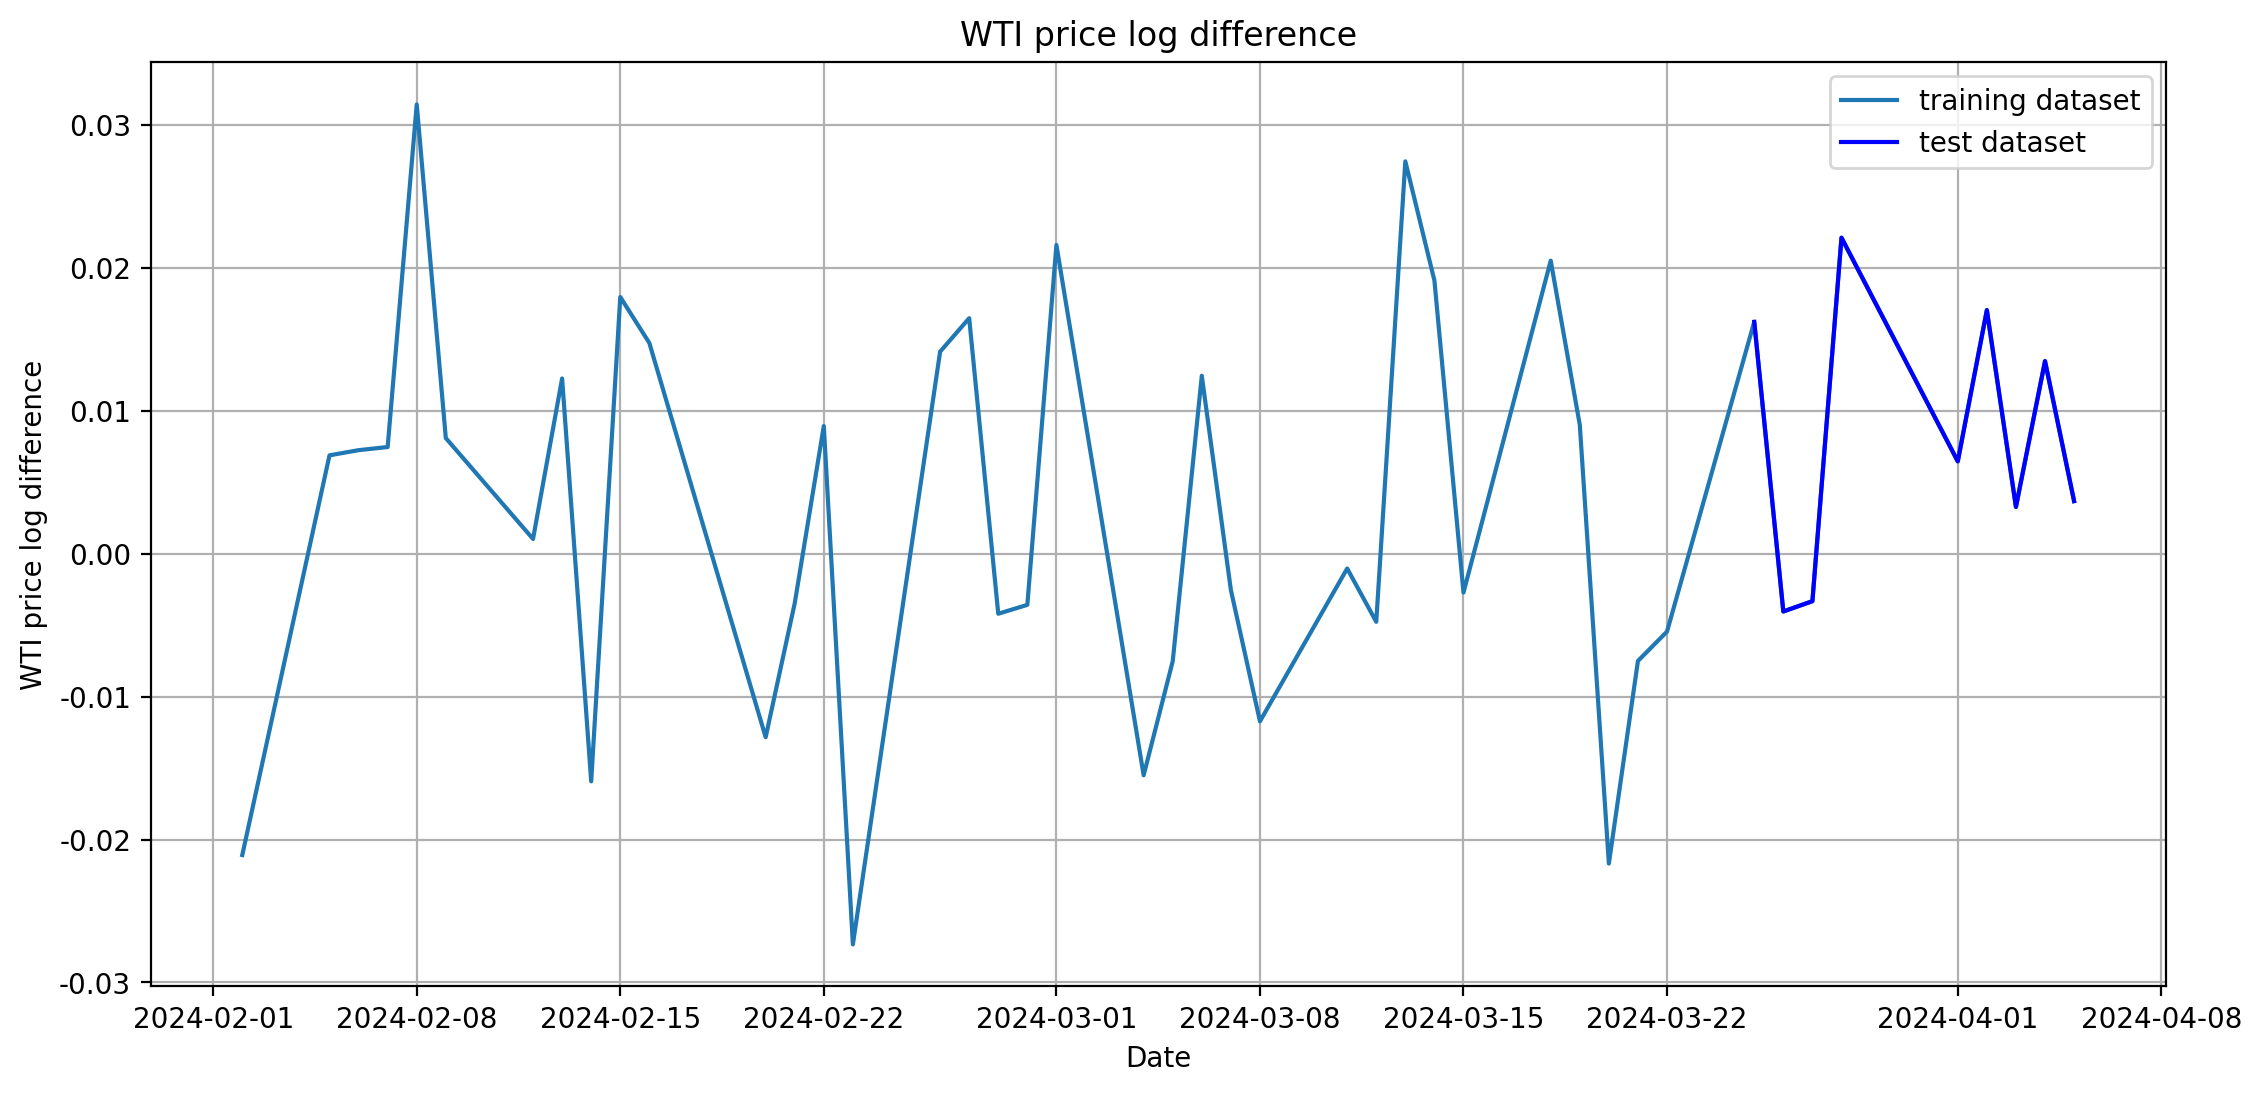

In [ ]:
train_data, test_data = wti_log_diff_1[:int(len(wti_log_diff_1)*0.8)], wti_log_diff_1[int(len(wti_log_diff_1)*0.8):]
plt.plot(wti_log_diff_1, label='training dataset')  # Used ts_log instead of train_data for better visualization
plt.plot(test_data, c='b', label='test dataset')
plt.title('WTI price log difference')
plt.xlabel('Date')
plt.ylabel('WTI price log difference')
plt.legend()
plt.grid(True)

In [ ]:
print(train_data.shape, test_data.shape)

(35,) (9,)


## 11- ARIMA model training

In [ ]:
# Define the ARIMA model
model = ARIMA(train_data, order=(1, 0, 1))

# Fit the ARIMA model
fitted_m = model.fit()

print(fitted_m.summary())


# OpenAI
client = openai.OpenAI(
api_key=os.environ['OPENAI_API_KEY'],
)

completion = openai.chat.completions.create(
    model="gpt-3.5-turbo",
    messages=[
        {
            "role": "user",
            "content": str(fitted_m.summary()) +
            'Feedback with simply meaning and conclusion in itemized list with easy understandable sentences.',
        },
    ],
    max_tokens = max_tokens,
    temperature = temperature
)
print('===================================================================================')
print('Summary of ARIMA model')
print(completion.choices[0].message.content)
print('-----------------------------------------------------------------------------------')
print(completion.usage)
print('===================================================================================')

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                   35
Model:                 ARIMA(1, 0, 1)   Log Likelihood                 101.054
Date:                Sun, 07 Apr 2024   AIC                           -194.109
Time:                        00:42:04   BIC                           -187.887
Sample:                             0   HQIC                          -191.961
                                 - 35                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0027      0.001      4.168      0.000       0.001       0.004
ar.L1          0.6932      0.281      2.466      0.014       0.142       1.244
ma.L1         -0.9959      3.389     -0.294      0.7

## 12- Predicting

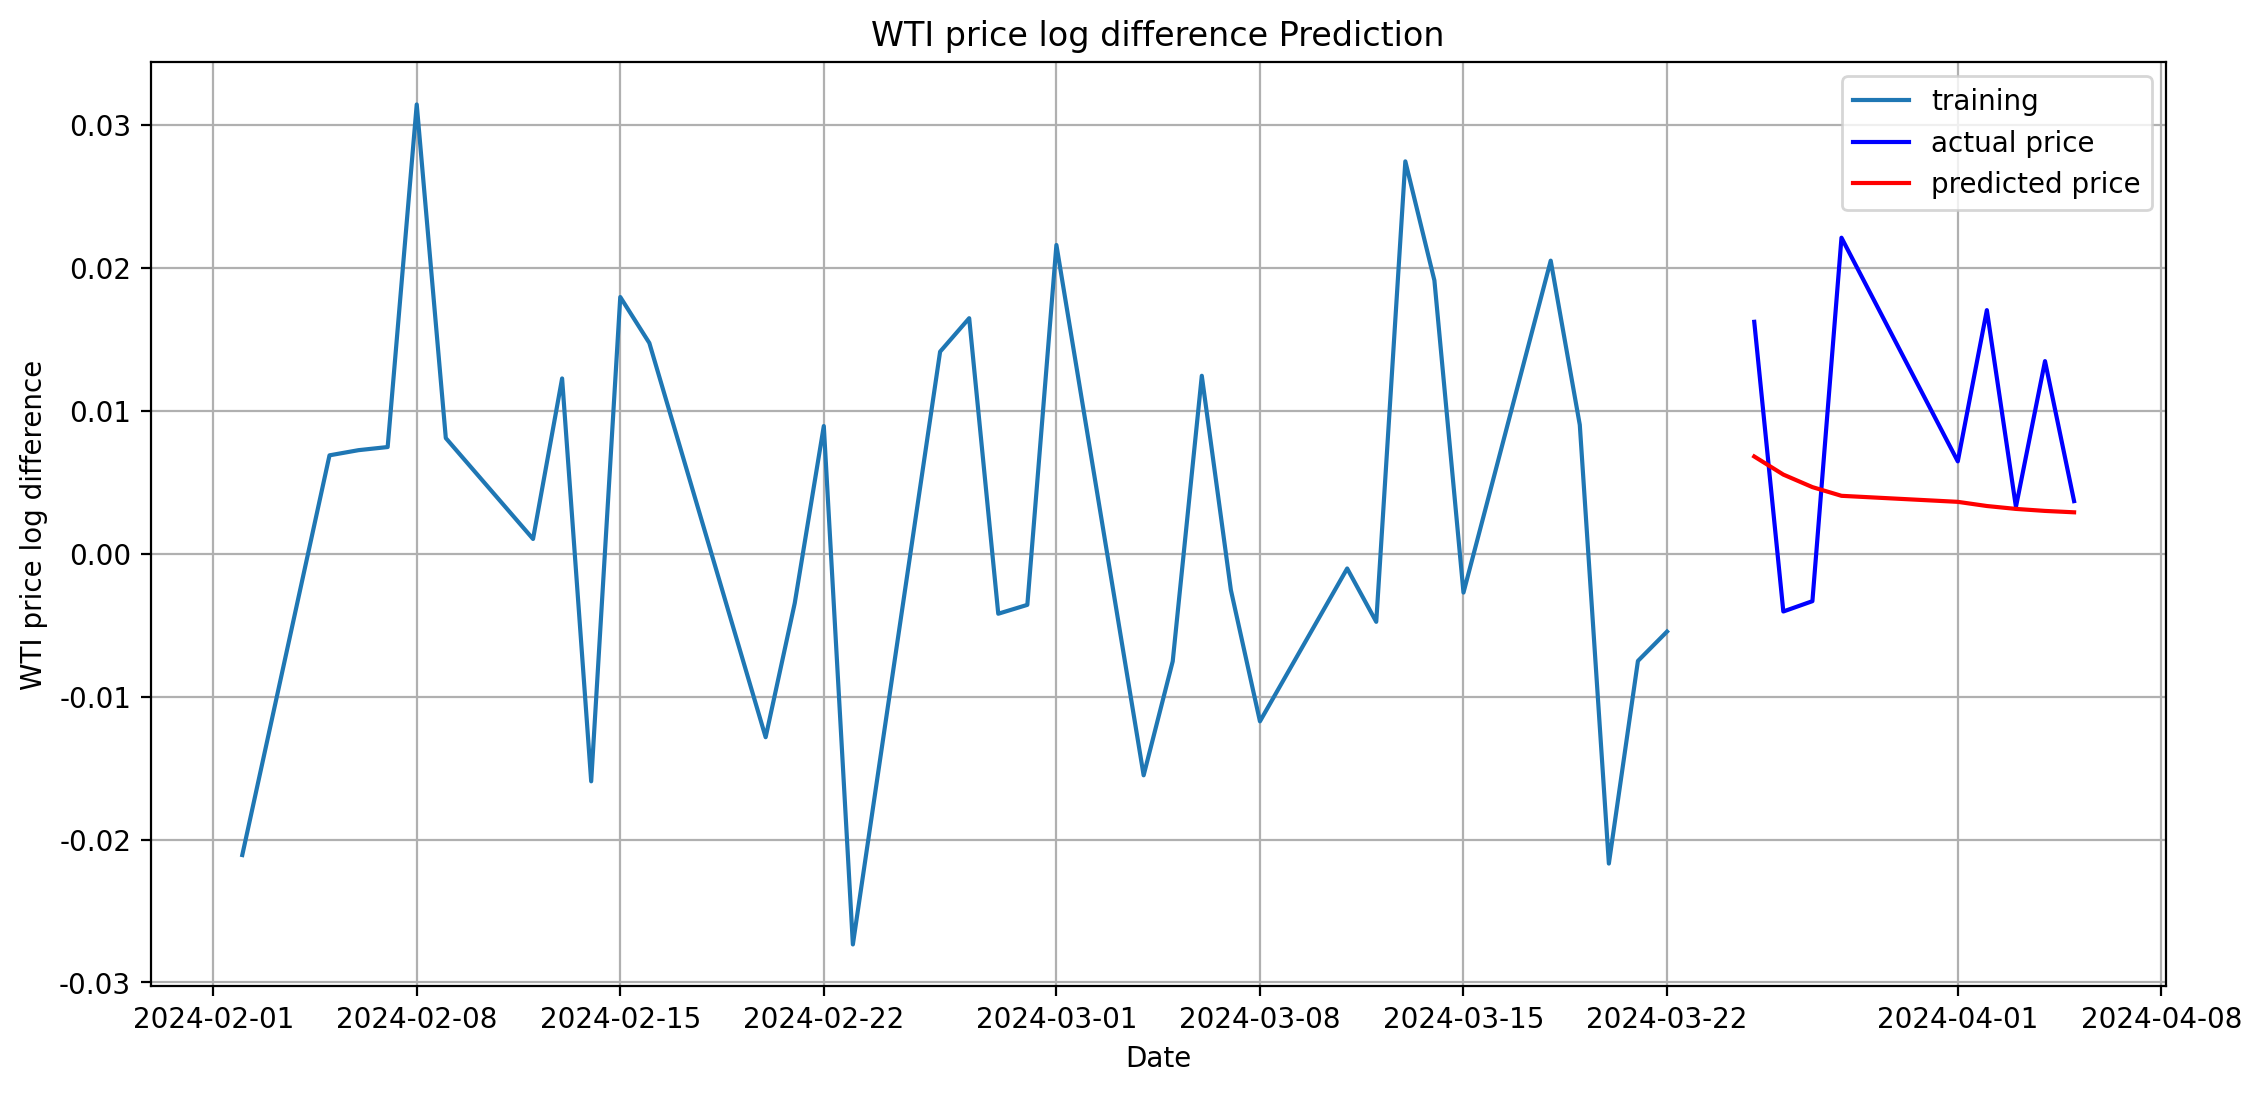

In [ ]:
# Forecast in future time
forecast = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
forecast = np.array(forecast)
# Make as pandas series
forecast_series = pd.Series(forecast, index=test_data.index)   # Forecasting data

# Plot
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(forecast_series, c='r',label='predicted price')
plt.title('WTI price log difference Prediction')
plt.xlabel('Date')
plt.ylabel('WTI price log difference')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Reverse the differencing function
def rev_diff(original_log_values, forecast, split_ratio):

    # Calculate the last index for the training data based on the provided split ratio
    last_train_index = int(len(original_log_values) * split_ratio) - 1

    # Extract the last value of the training data from the original logged values
    last_train_value = original_log_values[last_train_index]

    # Reverse the differencing process & convert to pandas series
    reversed_forecast = np.r_[last_train_value, forecast].cumsum()[1:]
    reversed_forecast = pd.Series(reversed_forecast, index=test_data.index)

    return reversed_forecast
    # return last_train_index, last_train_value

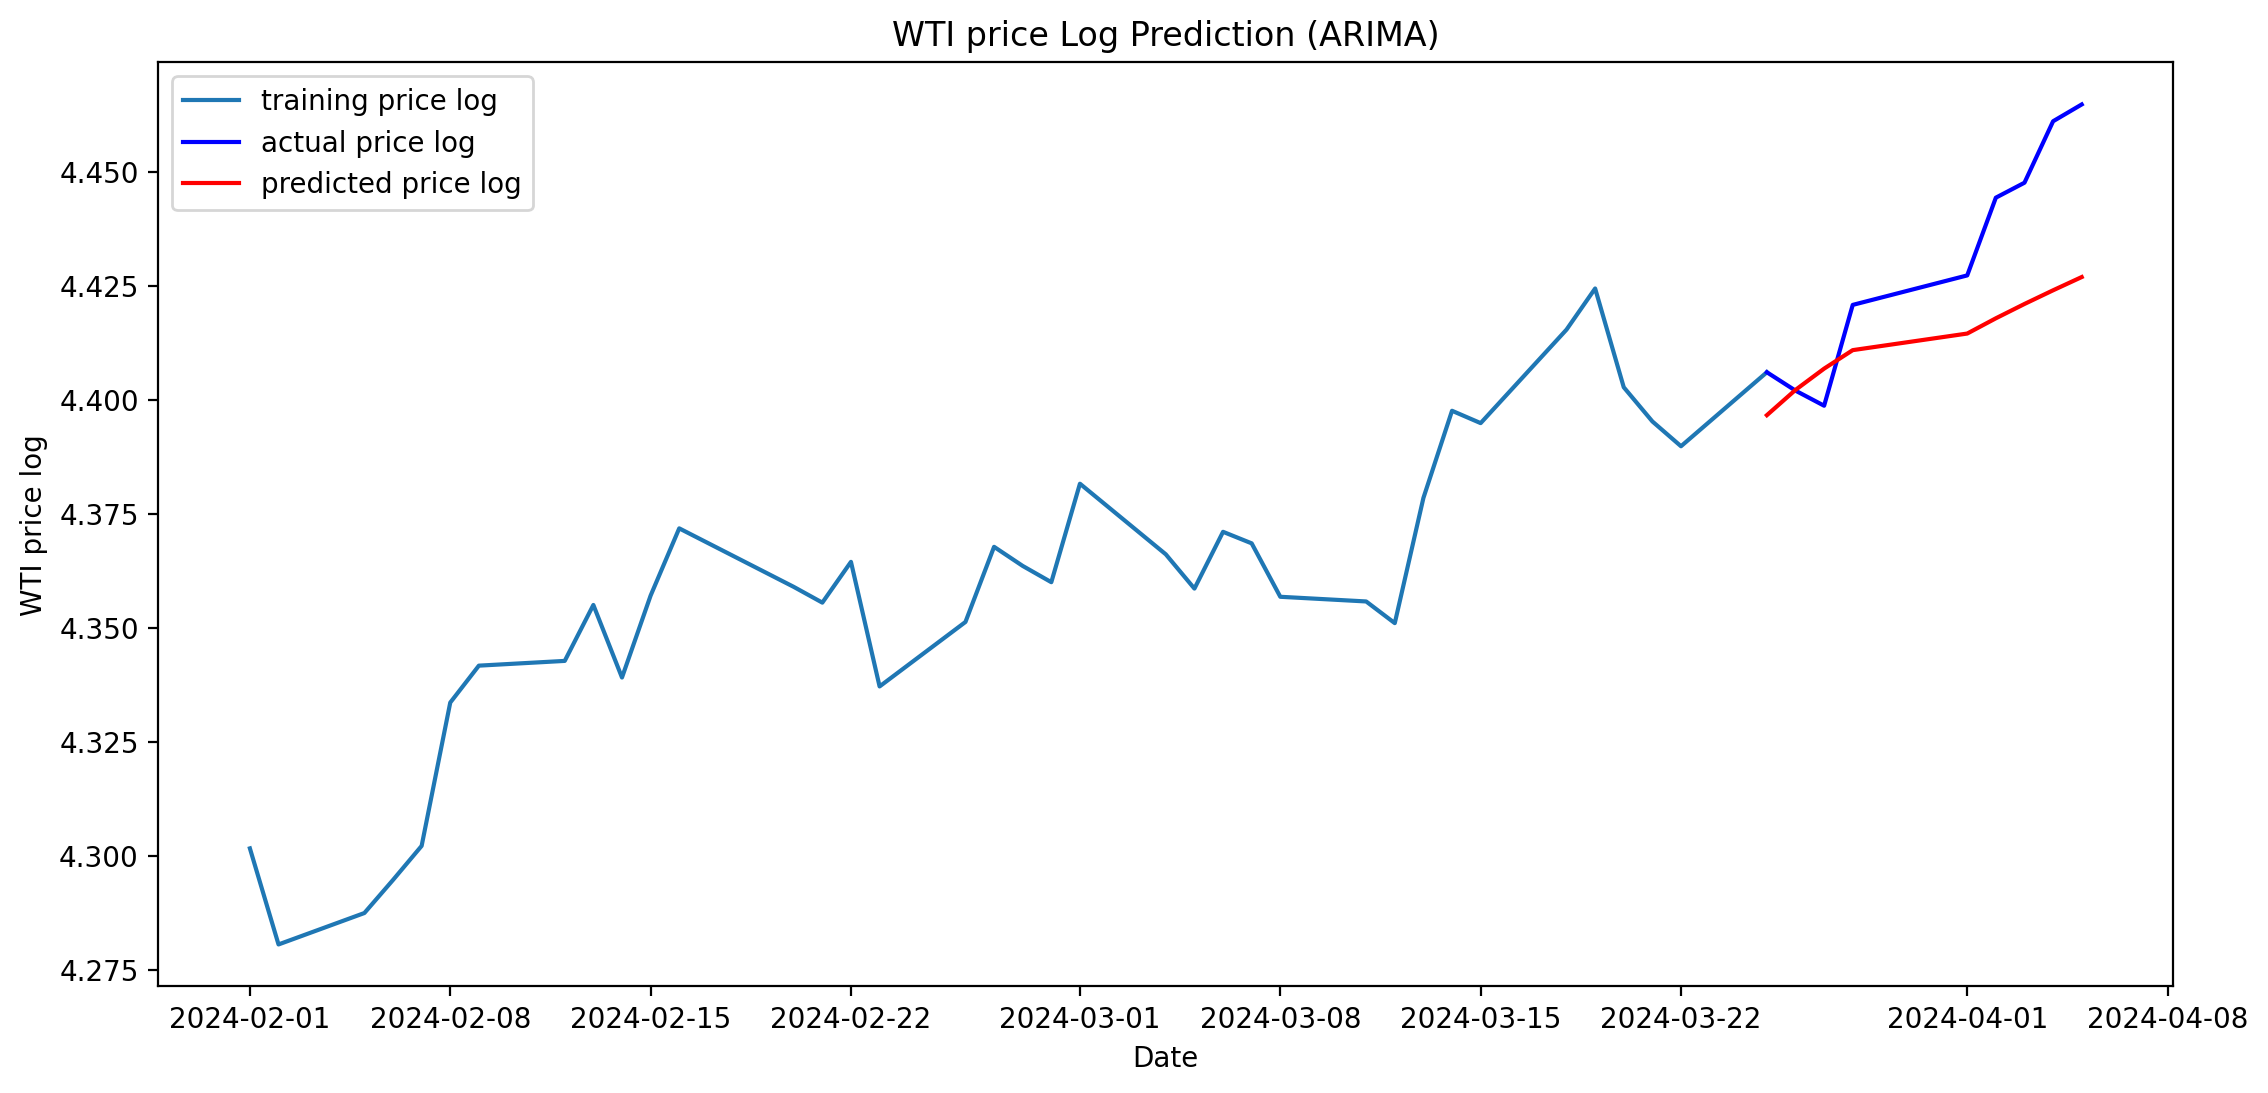

In [ ]:
# Reverse the differencing process
train_log = wti_log[:int(len(wti_log_diff_1)*0.8)+2]
test_log = wti_log[int(len(wti_log_diff_1)*0.8)+1:]
forecast_log = rev_diff(wti_log, forecast, 0.8)

# Plot log values of train, test, and forecast data
plt.plot(train_log, label='training price log')
plt.plot(test_log, label='actual price log', c='b')
plt.plot(forecast_log, label='predicted price log', c='r')
plt.title('WTI price Log Prediction (ARIMA)')
plt.xlabel('Date')
plt.ylabel('WTI price log')
plt.legend()

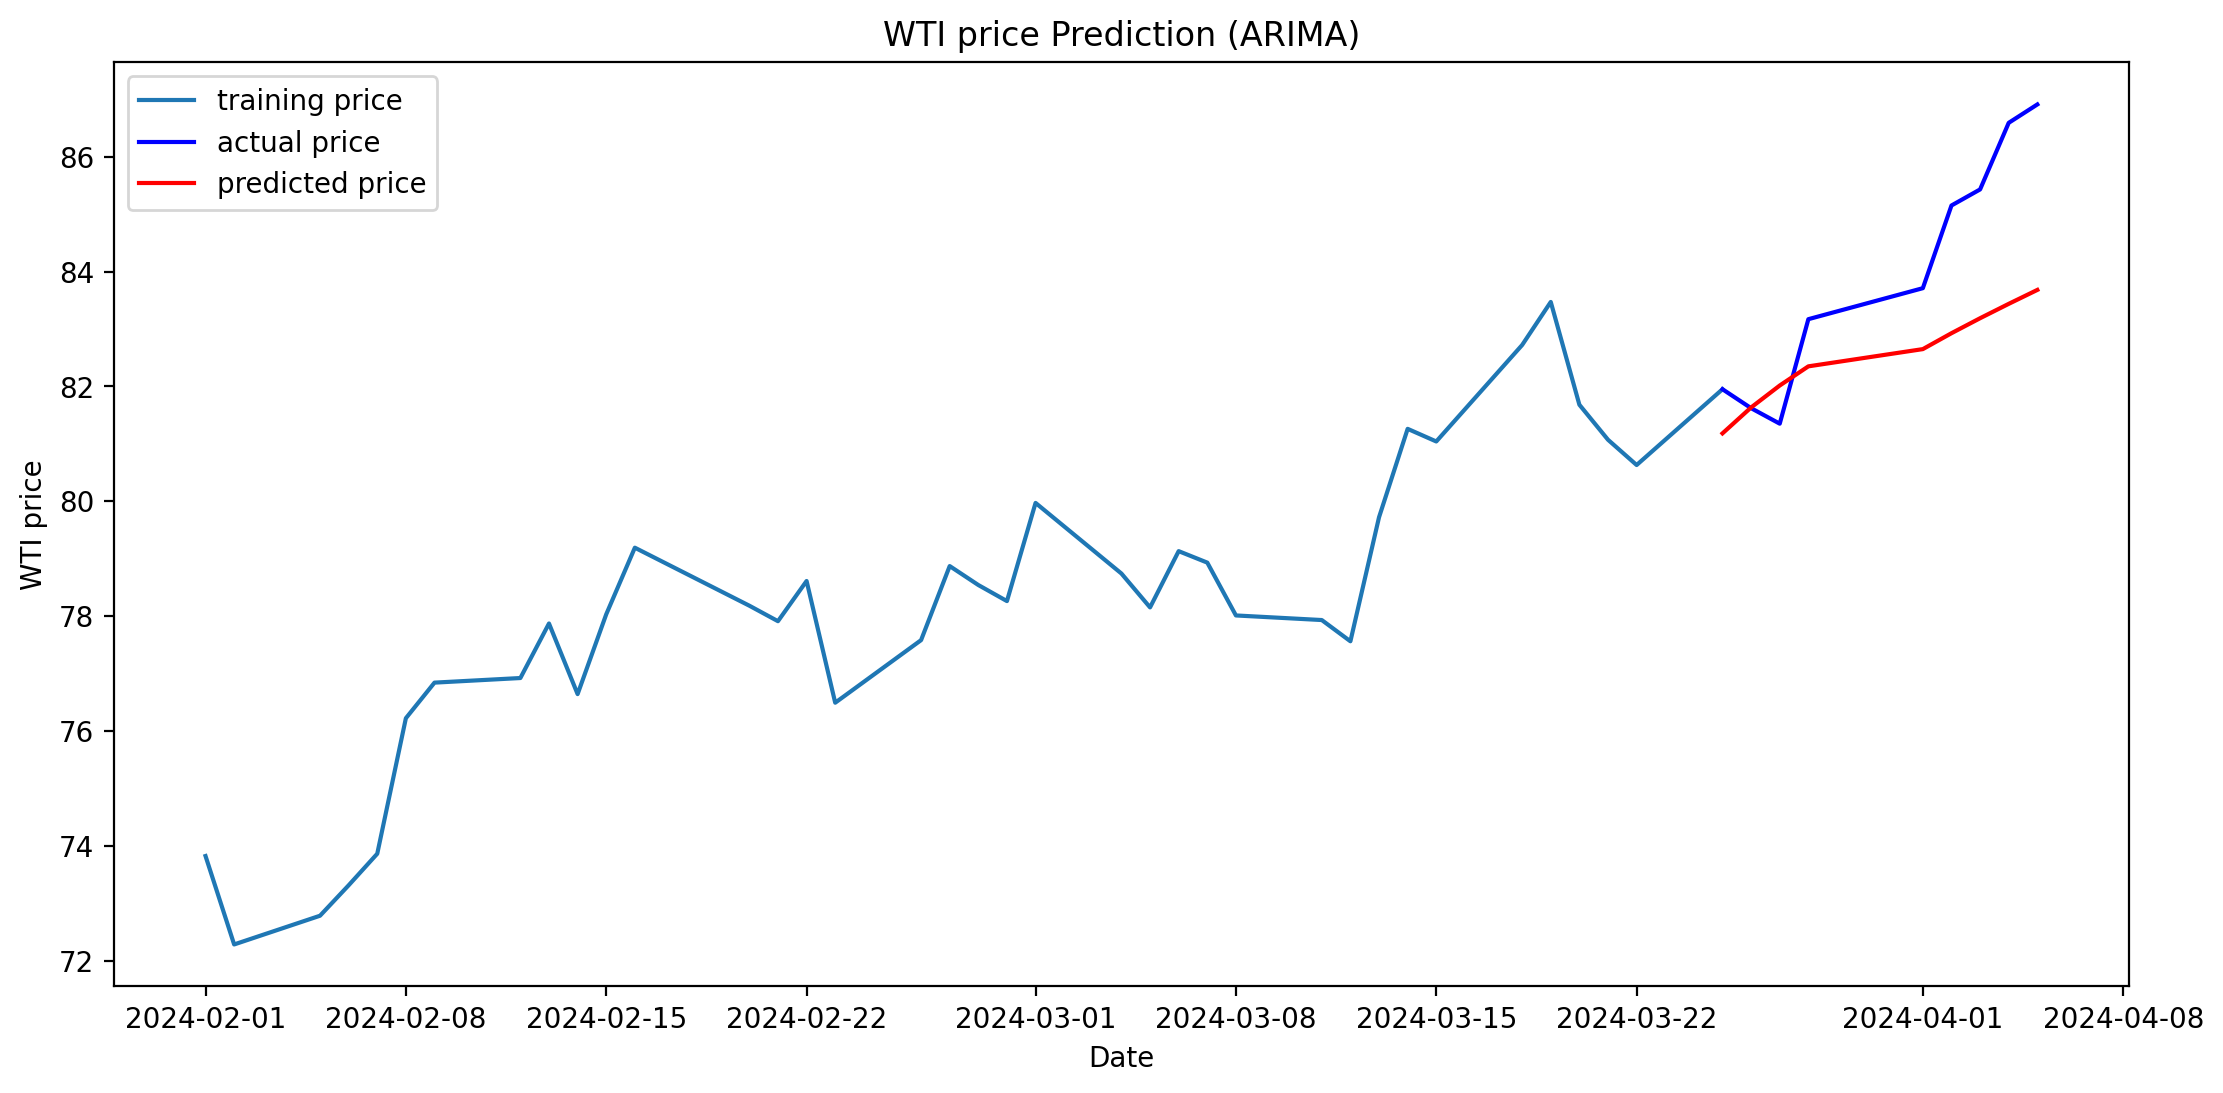

In [ ]:
# Reverse the differencing process
train_log = wti_log[:int(len(wti_log_diff_1)*0.8)+2]
test_log = wti_log[int(len(wti_log_diff_1)*0.8+1):]
forecast_log = rev_diff(wti_log, forecast, 0.8)

# Plot log values of train, test, and forecast data
plt.plot(np.exp(train_log), label='training price')
plt.plot(np.exp(test_log), label='actual price', c='b')
plt.plot(np.exp(forecast_log), label='predicted price', c='r')
plt.title('WTI price Prediction (ARIMA)')
plt.xlabel('Date')
plt.ylabel('WTI price')
plt.legend()

## 13- Evaluation

In [ ]:
print(train_data.shape, test_data.shape)
print(train_log.shape, test_log.shape, forecast_log.shape)

(35,) (9,)
(37,) (9,) (9,)


In [ ]:
mse = mean_squared_error(np.exp(test_log), np.exp(forecast_log))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_log), np.exp(forecast_log))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_log), np.exp(forecast_log)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(forecast_log) - np.exp(test_log))/np.abs(np.exp(test_log)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  3.6876590967818337
MAE:  1.5755293824677352
RMSE:  1.9203278617938744
MAPE: 1.85%


## 14- Grid search the optimum parameters for ARIMA model

Grid Search Progress: 100%|██████████| 64/64 [00:19<00:00,  3.21it/s]


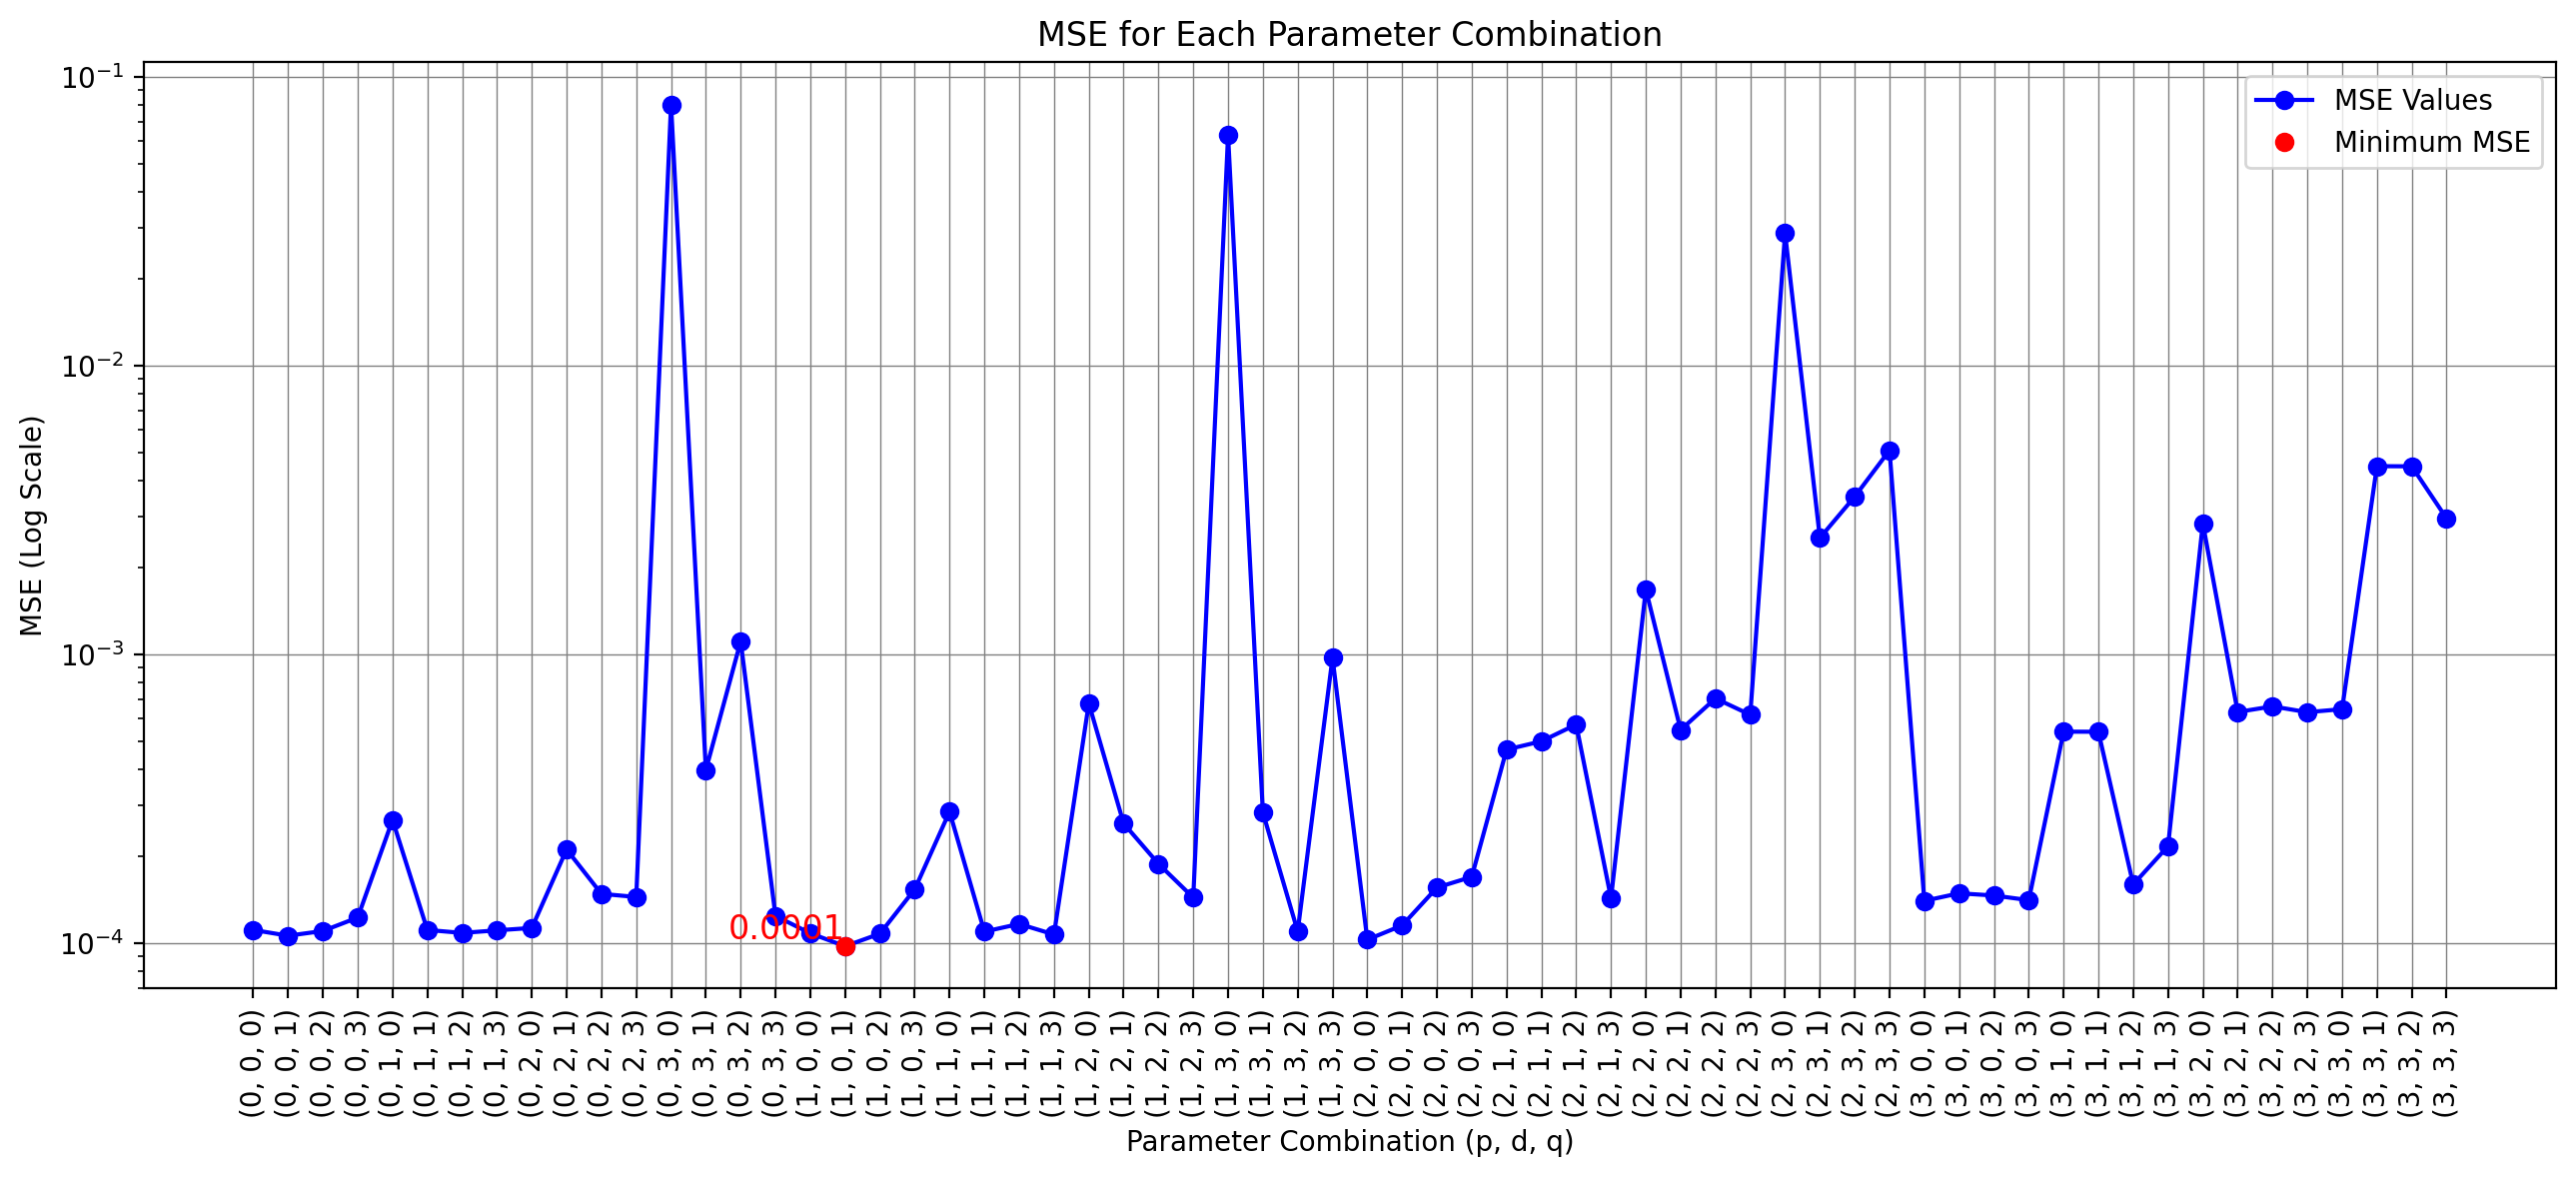

Best ARIMA(1, 0, 1) MSE=0.0001
MSE:  9.933376635757605e-05
MAE:  0.00817875500096891
RMSE:  0.00996663264887274
MAPE: nan%


In [ ]:
## Grid Search for ARIMA Model version 1.0 by Kenny Jung

import itertools  # Library for iteration tools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA  # Library for ARIMA model
from sklearn.metrics import mean_squared_error
from tqdm import tqdm  # Library for progress bar
import math
plt.rcParams['axes.unicode_minus'] = False  # This disables using the unicode minus

# Define the p, d, q parameters to take any value between numbers
p = d = q = range(0, 4)

# Generate the list of all different combinations of p, d, and q triplets
pdq = list(itertools.product(p, d, q))

# Define mse, param values, best score, and best cfg
mse_values = []  # Mean Squared Error (MSE) values
param_values = []  # Parameter values
best_score, best_cfg = float("inf"), None  # Best score and best configuration

# Iterate over all the paramaters
for param in tqdm(pdq, desc='Grid Search Progress'):
    try:
        model = ARIMA(train_data, order=param)
        fitted_model = model.fit()
        forecast = fitted_model.forecast(len(test_data))
        mse = mean_squared_error(test_data, forecast)
        mse_values.append(mse)
        param_values.append(param)

        if mse < best_score:
            best_score, best_cfg = mse, param
    except:
        continue

# Train the best model
model = ARIMA(train_data, order=best_cfg)
fitted_model = model.fit()
forecast = fitted_model.forecast(len(test_data))

# Create a MSE series
mse_series = pd.Series(mse_values, index=[str(p) for p in pdq])

# Find the minimum value and its position (parameter combination) from the MSE series
min_mse_value = min(mse_values)
min_mse_index = mse_values.index(min_mse_value)
min_mse_param = param_values[min_mse_index]

# Plot a line graph for all MSE values
plt.plot(mse_series.index, mse_values, 'b-', marker='o', label='MSE Values')

# Highlight the minimum MSE value with a red marker
plt.plot(mse_series.index[min_mse_index], min_mse_value, 'ro', label='Minimum MSE')

# Add text for the minimum MSE value (with an offset proportional to min_mse_value for y position adjustment)
plt.text(mse_series.index[min_mse_index], min_mse_value, f'{min_mse_value:.4f}', rotation=0, ha='right', va='bottom', color='red', fontsize=12)

# Set the title, labels, and legend
plt.title('MSE for Each Parameter Combination')
plt.xlabel('Parameter Combination (p, d, q)')
plt.xticks(rotation=90, fontsize=10)
plt.ylabel('MSE (Log Scale)')
plt.yscale('log')
plt.grid(which='major', linestyle='-', linewidth='0.5', color='gray')
plt.legend()
plt.tight_layout()
plt.show()

# Print the best parameters
print('Best ARIMA%s MSE=%.4f' % (best_cfg, best_score))

# Print MSE, MAE, RMSE, MAPE values
mse = mean_squared_error(np.exp(test_data), np.exp(forecast))
print('MSE: ', mse)
mae = mean_absolute_error(np.exp(test_data), np.exp(forecast))
print('MAE: ', mae)
rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(forecast)))
print('RMSE: ', rmse)
mape = np.mean(np.abs(np.exp(forecast) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

## 15- SARIMA model training

In [ ]:
# Define the SARIMA model
model = SARIMAX(train_data, order=(1, 2, 2), seasonal_order=(0, 0, 1, 7))

# Fit the SARIMA model
fitted_m = model.fit()

print(fitted_m.summary())

# OpenAI API Key
client = openai.OpenAI(
api_key=os.environ['OPENAI_API_KEY'],
)

completion = openai.chat.completions.create(
    model="gpt-3.5-turbo",
    messages=[
        {
            "role": "user",
            "content": str(fitted_m.summary()) +
            'Feedback with simply meaning and conclusion in itemized list with easy understandable sentences.',
        },
    ],
    max_tokens = max_tokens,
    temperature = temperature
)
print('===================================================================================')
print('Summary of ARIMA model')
print(completion.choices[0].message.content)
print('-----------------------------------------------------------------------------------')
print(completion.usage)
print('===================================================================================')

                                      SARIMAX Results                                      
Dep. Variable:                               Close   No. Observations:                   35
Model:             SARIMAX(1, 2, 2)x(0, 0, [1], 7)   Log Likelihood                  80.636
Date:                             Sun, 07 Apr 2024   AIC                           -151.271
Time:                                     00:42:56   BIC                           -143.788
Sample:                                          0   HQIC                          -148.753
                                              - 35                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7409      1.035     -0.716      0.474      -2.770       1.288
ma.L1         -0.1856      

## 16- Predicting

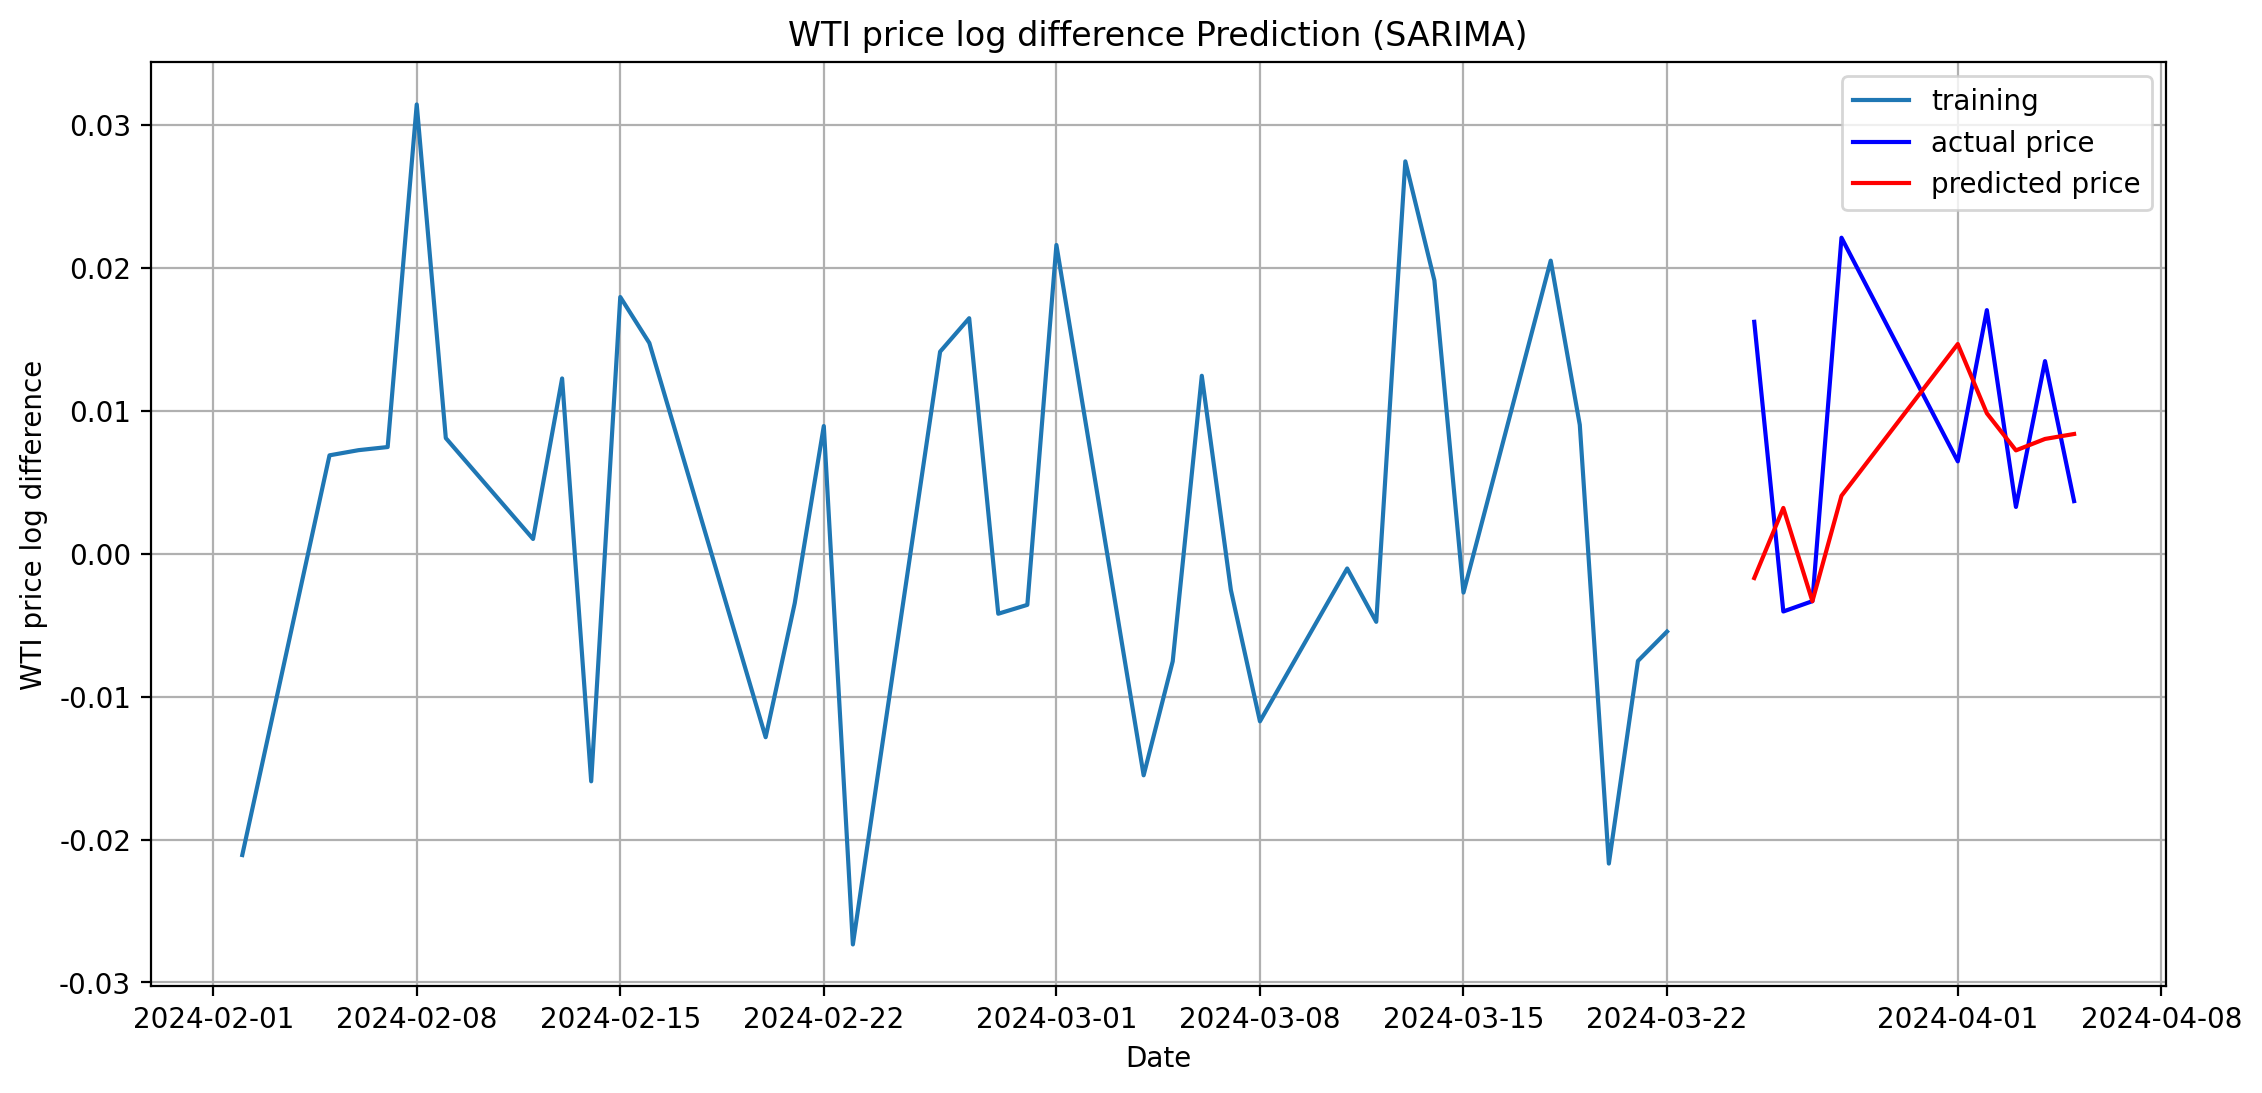

In [ ]:
# Forecast in future time
forecast = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
forecast = np.array(forecast)
# Make as pandas series
forecast_series = pd.Series(forecast, index=test_data.index)   # Forecasting data

# Plot
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(forecast_series, c='r',label='predicted price')
plt.title('WTI price log difference Prediction (SARIMA)')
plt.xlabel('Date')
plt.ylabel('WTI price log difference')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Reverse the differencing function
def rev_diff(original_log_values, forecast, split_ratio):

    # Calculate the last index for the training data based on the provided split ratio
    last_train_index = int(len(original_log_values) * split_ratio) - 1

    # Extract the last value of the training data from the original logged values
    last_train_value = original_log_values[last_train_index]

    # Reverse the differencing process & convert to pandas series
    reversed_forecast = np.r_[last_train_value, forecast].cumsum()[1:]
    reversed_forecast = pd.Series(reversed_forecast, index=test_data.index)

    return reversed_forecast
    # return last_train_index, last_train_value

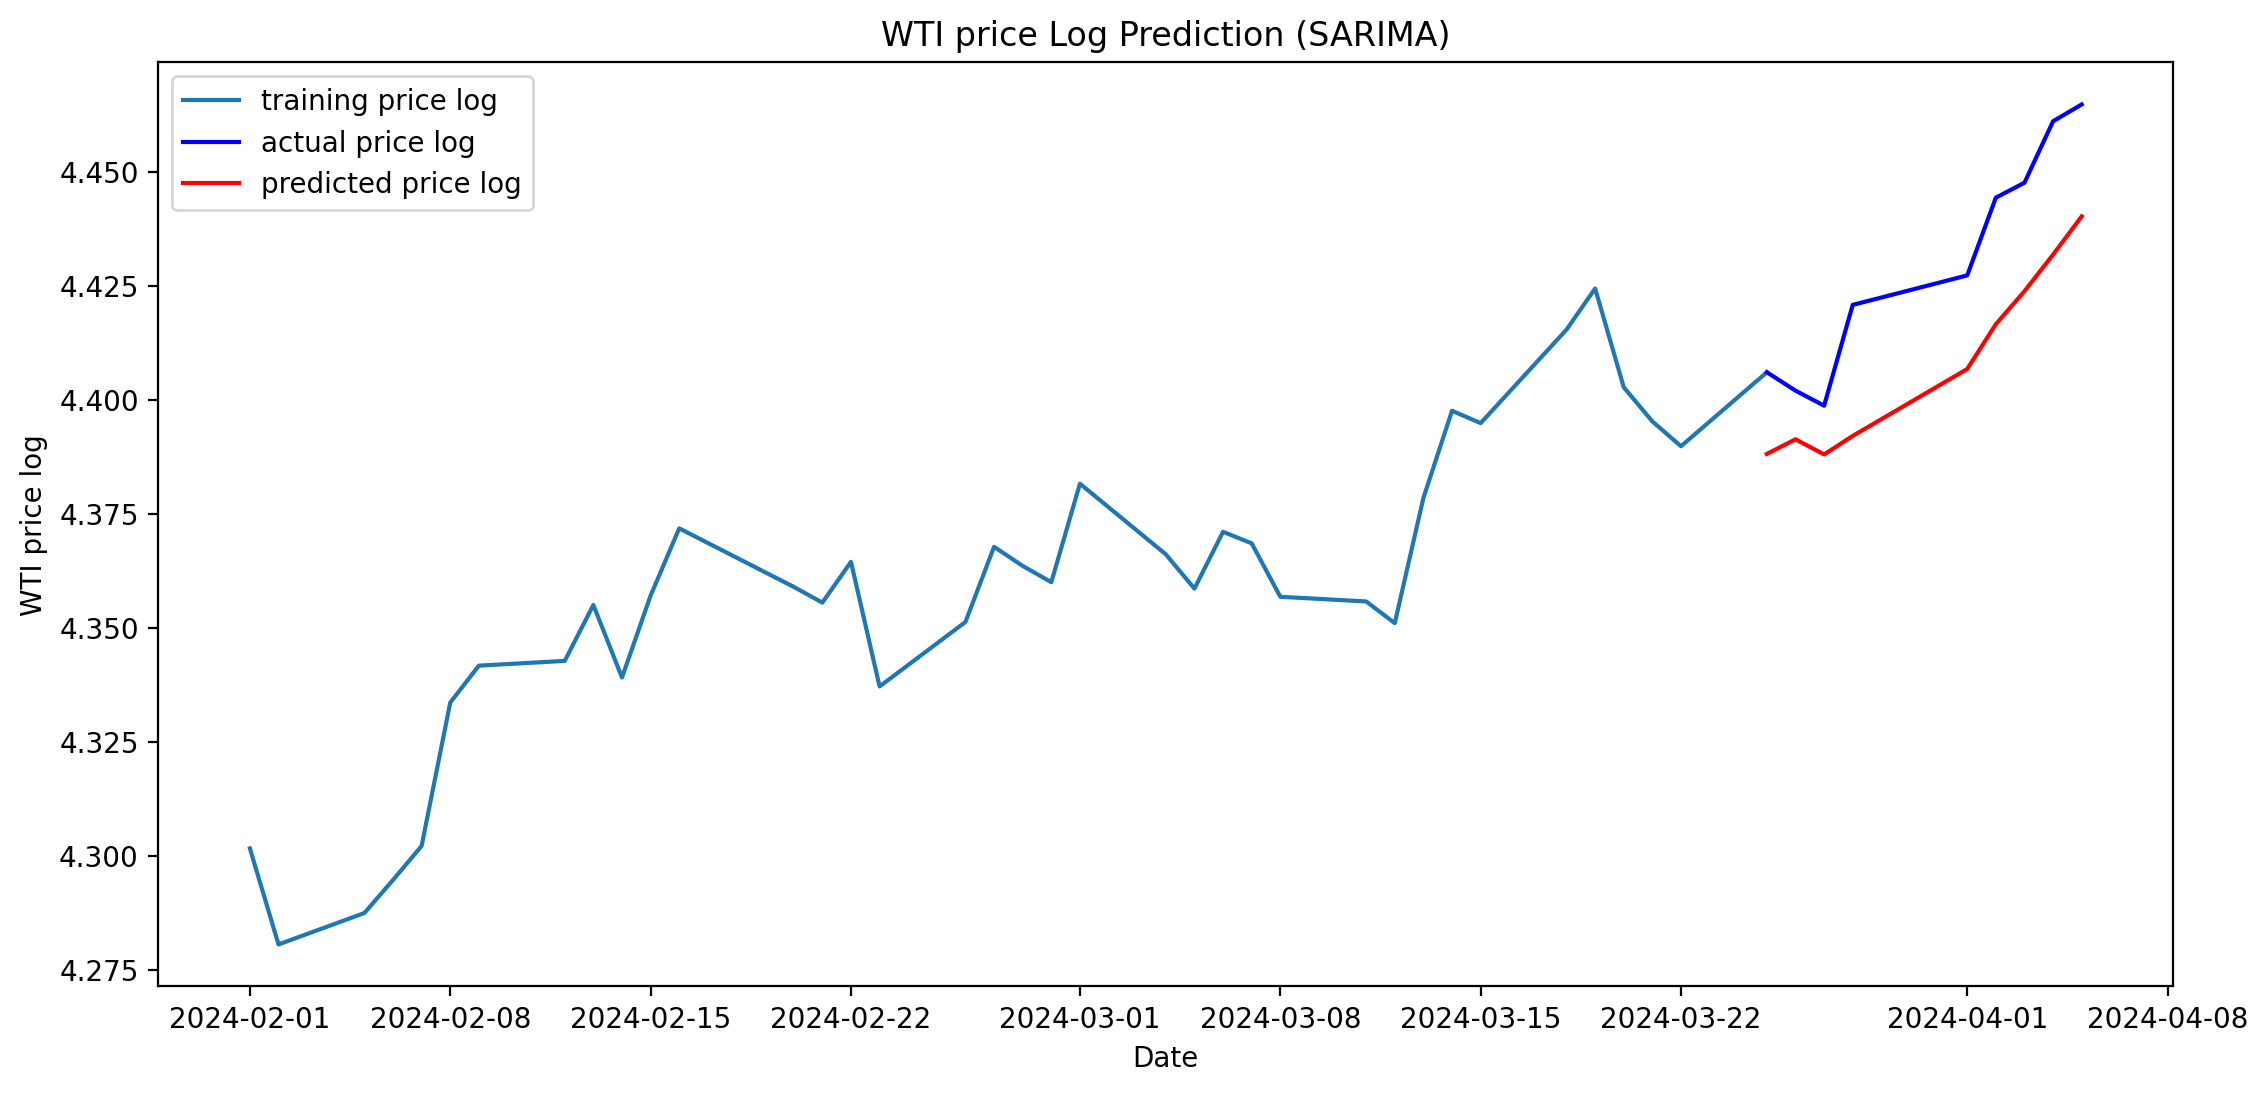

In [ ]:
# Reverse the differencing process
train_log = wti_log[:int(len(wti_log_diff_1)*0.8)+2]
test_log = wti_log[int(len(wti_log_diff_1)*0.8+1):]
forecast_log = rev_diff(wti_log, forecast, 0.8)

# Plot log values of train, test, and forecast data
plt.plot(train_log, label='training price log')
plt.plot(test_log, label='actual price log', c='b')
plt.plot(forecast_log, label='predicted price log', c='r')
plt.title('WTI price Log Prediction (SARIMA)')
plt.xlabel('Date')
plt.ylabel('WTI price log')
plt.legend()

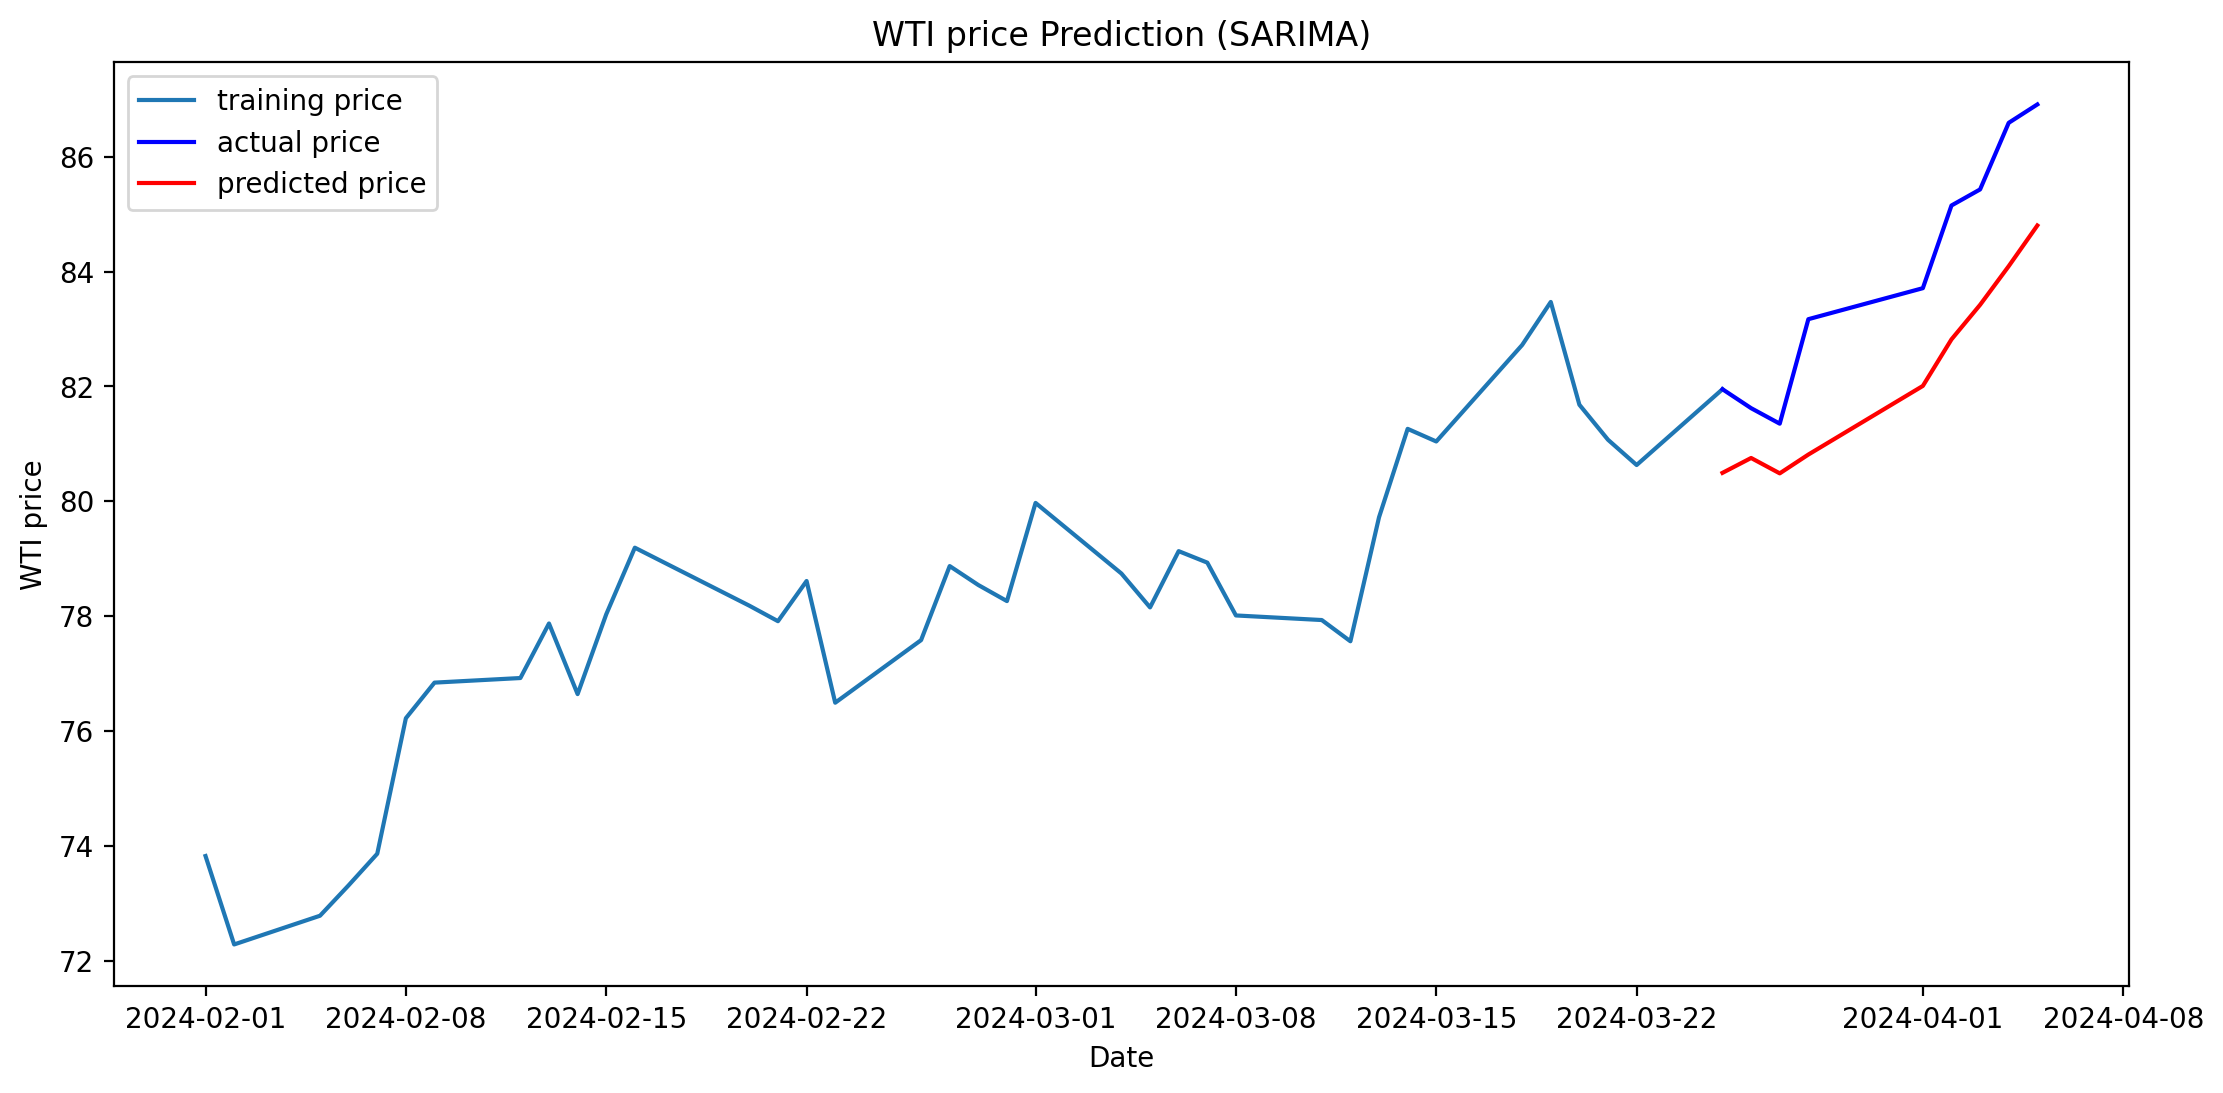

In [ ]:
# Reverse the differencing process
train_log = wti_log[:int(len(wti_log_diff_1)*0.8)+2]
test_log = wti_log[int(len(wti_log_diff_1)*0.8+1):]
forecast_log = rev_diff(wti_log, forecast, 0.8)

# Plot log values of train, test, and forecast data
plt.plot(np.exp(train_log), label='training price')
plt.plot(np.exp(test_log), label='actual price', c='b')
plt.plot(np.exp(forecast_log), label='predicted price', c='r')
plt.title('WTI price Prediction (SARIMA)')
plt.xlabel('Date')
plt.ylabel('WTI price')
plt.legend()

## 17- Evaluation

In [ ]:
print(train_data.shape, test_data.shape)
print(train_log.shape, test_log.shape, forecast_log.shape)

(35,) (9,)
(37,) (9,) (9,)


In [ ]:
mse = mean_squared_error(np.exp(test_log), np.exp(forecast_log))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_log), np.exp(forecast_log))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_log), np.exp(forecast_log)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(forecast_log) - np.exp(test_log))/np.abs(np.exp(test_log)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  3.5815838763781063
MAE:  1.7995457009806144
RMSE:  1.8925072988969174
MAPE: 2.13%


## 18- Grid search the optimum parameters for SARIMA model

param Grid Search Progress: 100%|██████████| 27/27 [10:41<00:00, 23.77s/it]


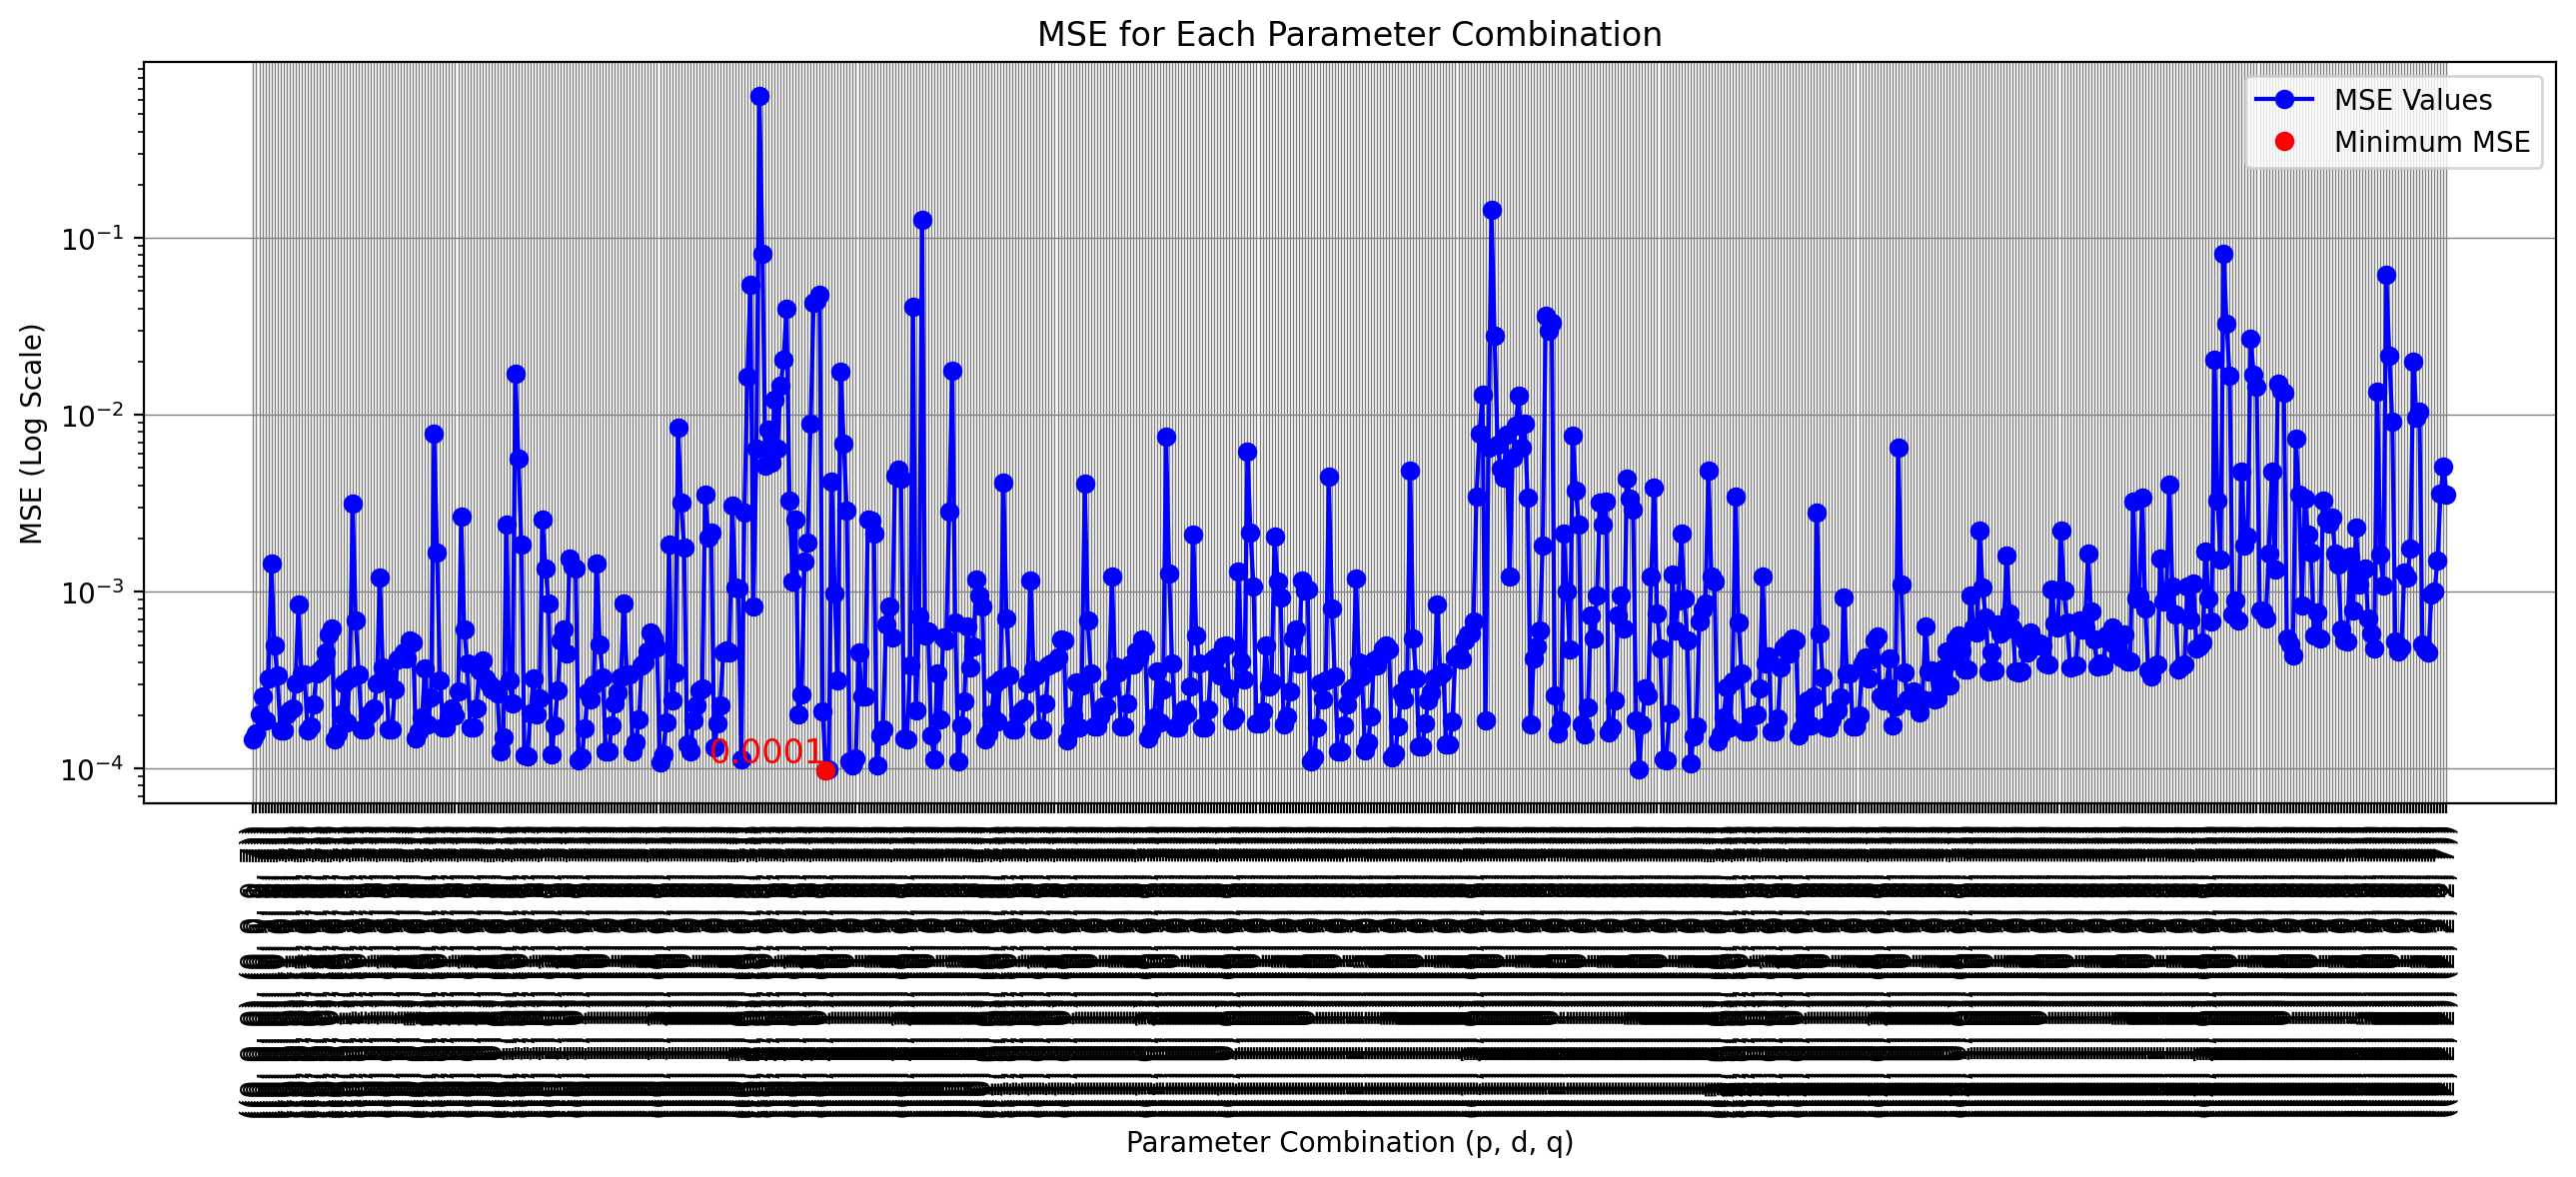

Best SARIMA((0, 2, 1), (0, 0, 1, 7)) MSE=0.0001
MSE:  0.00010024882346411023
MAE:  0.008195505775142066
RMSE:  0.010012433443679426
MAPE: nan%


In [ ]:
## Grid Search for SARIMA Model version 1.0 by Kenny Jung

import itertools  # Library for iteration tools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX  # Library for SARIMA model
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
from tqdm import tqdm  # Library for progress bar

# Define the p, d, q parameters to take any value between numbers
p = d = q = range(0, 3)

# Generate the list of all different combinations of p, d, and q triplets
pdq = list(itertools.product(p, d, q))

# Generate the list of all different combinations of seasonal p, d, and q triplets (under 12 for seasonal parameter)
seasonal_pdq = [(x[0], x[1], x[2], 7) for x in list(itertools.product(p, d, q))]

# Define mse, param values, best score, and best cfg
mse_values = []  # Mean Squared Error (MSE) values
param_values = []  # Parameter values
best_score, best_cfg = float("inf"), None  # Best score and best configuration

# Iterate over all the paramaters
for param in tqdm(pdq, desc='param Grid Search Progress'):
    for param_seasonal in seasonal_pdq:
        try:
            model = SARIMAX(train_data, order=param, seasonal_order=param_seasonal)
            fitted_model = model.fit(disp=False)
            forecast = fitted_model.forecast(len(test_data))
            mse = mean_squared_error(test_data, forecast)
            mse_values.append(mse)
            param_values.append((param, param_seasonal))

            if mse < best_score:
                best_score, best_cfg = mse, (param, param_seasonal)
        except:
            continue

# Train the best model
model = SARIMAX(train_data, order=best_cfg[0], seasonal_order=best_cfg[1])
fitted_model = model.fit()
forecast = fitted_model.forecast(len(test_data))

# Create a MSE series
mse_series = pd.Series(mse_values, index=[str(p) for p in param_values])

# Find the minimum value and its position (parameter combination) from the MSE series
min_mse_value = min(mse_values)
min_mse_index = mse_values.index(min_mse_value)
min_mse_param = param_values[min_mse_index]

# Plot a line graph for all MSE values
plt.plot(mse_series.index, mse_values, 'b-', marker='o', label='MSE Values')

# Highlight the minimum MSE value with a red marker
plt.plot(mse_series.index[min_mse_index], min_mse_value, 'ro', label='Minimum MSE')

# Add text for the minimum MSE value (with an offset proportional to min_mse_value for y position adjustment)
plt.text(mse_series.index[min_mse_index], min_mse_value, f'{min_mse_value:.4f}', rotation=0, ha='right', va='bottom', color='red', fontsize=12)

# Set the title, labels, and legend
plt.title('MSE for Each Parameter Combination')
plt.xlabel('Parameter Combination (p, d, q)')
plt.xticks(rotation=90, fontsize=10)
plt.ylabel('MSE (Log Scale)')
plt.yscale('log')
plt.grid(which='major', linestyle='-', linewidth='0.5', color='gray')
plt.legend()
plt.tight_layout()
plt.show()

# Print the best parameters
print('Best SARIMA%s MSE=%.4f' % (best_cfg, best_score))

# Print MSE, MAE, RMSE, MAPE values
mse = mean_squared_error(np.exp(test_data), np.exp(forecast))
print('MSE: ', mse)
mae = mean_absolute_error(np.exp(test_data), np.exp(forecast))
print('MAE: ', mae)
rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(forecast)))
print('RMSE: ', rmse)
mape = np.mean(np.abs(np.exp(forecast) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))
